In [1]:
import sys, os

if 'BigRed200' in os.getcwd().split('/'):
    print('Running on BigRed200')
    sys.path.insert(0,'/geode2/home/u080/sheybani/BigRed200/spenv/lib/python3.10/site-packages')


Running on BigRed200


In [2]:
import torch, torchvision
import numpy as np
import pandas as pd
from torch.nn import functional as F

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from itertools import chain
import pickle
from sklearn import decomposition
from copy import deepcopy
import joblib

import torch.nn as nn

In [3]:
from pathlib import Path
def get_fpathlist(vid_root, subjdir, ds_rate=1):
    # read the image file names into fpathlist
    # subjdir = ['008MS'] #@@@

    # vid_root = r"/N/project/infant_image_statistics/03_JPG_AllMasters/"
    
    fpathlist = sorted(list(Path(os.path.join(vid_root, subjdir)).iterdir()), 
                       key=lambda x: x.name)
    fpathlist = [str(fpath) for fpath in fpathlist if fpath.suffix=='.jpg']
    fpathlist = fpathlist[::ds_rate]
    return fpathlist #TemporalNeighborhoodDataset(fpathlist, transform=get_transform(image_size))

In [4]:
jpg_root = '/N/project/infant_image_statistics/video_frames/' #30fps
# "/N/project/infant_image_statistics/preproc_saber/JPG_10fps/"

# subj_dir = '049JC'#'008MS'#
# ds_rate = 1


# fpathlist = get_fpathlist(jpg_root, subj_dir, ds_rate=ds_rate)
# print(len(fpathlist))

In [5]:
# g0='008MS+009SS_withrotation+010BF_withrotation+011EA_withrotation+012TT_withrotation+013LS+014SN+015JM+016TF+017EW_withrotation'
g0='008MS+009SS+010BF+011EA+012TT+013LS+014SN+015JM+016TF+017EW'
# g1='026AR+027SS+028CK+028MR+029TT+030FD+031HW+032SR+033SE+034JC_withlighting'
# g2='043MP+044ET+046TE+047MS+048KG+049JC+050AB+050AK_rotation+051DW'
g2='043MP+044ET+046TE+047MS+048KG+049JC+050AB+050AK+051DW'
subj_dirs = g0.split('+')
subj_dirs = sorted([item for item in subj_dirs
                    if os.path.isdir(jpg_root+item)])
ds_rate = 1
fpathlist = []
for i_subj, subjdir in enumerate(subj_dirs):
    fpathlist += get_fpathlist(jpg_root, subjdir, ds_rate=ds_rate)
print(len(fpathlist))

5274809


In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [10]:
70*5274809/(1024*1024)

352.13149070739746

In [11]:
import skimage
def center_crop(img, crop_size):
    # crop_size: int divisible by 
    # img size: divisible by 2
    if len(img.shape)==2:
        img = np.expand_dim(img,2)
    h,w,c = img.shape
    csh = crop_size//2
    hh, wh = h//2, w//2
    
    i_st = hh-csh
    i_end = hh+csh
    j_st = wh-csh
    j_end = wh+csh
    
    return img[i_st:i_end, j_st:j_end,:]
def get_transform(image_size):

    # transform = tr.Compose([
    #     tr.Resize(image_size),
    #     tr.CenterCrop(image_size),
    #     tr.ConvertImageDtype(torch.float32),
    #     tr.Normalize(mean,std)
    # ])
    def xtransform(img): 
        
        if len(img.shape)==2:
            img = np.expand_dim(img,2)
        h,w, c = img.shape
        
        scale_f = image_size/min(h,w)
        img_res = skimage.transform.rescale(img, scale_f, anti_aliasing=True, channel_axis=2)
        img_res = skimage.util.img_as_ubyte(img_res)
        cc = center_crop(img_res, image_size)
        cc_gs = skimage.color.rgb2gray(cc)
        return cc_gs
        
    return xtransform

def _proc_image(fpath, transform):

    # load
    img = skimage.io.imread(fpath)
    if img is None:
        warnings.warn('Image file at '+fpath+' could not be read!')
        return
    # transform (Reize)
    if transform is not None:
        img = transform(img)
    return img

In [24]:
transform = get_transform(32)

sample = fpathlist[0:8:2]
n_jobs=10
inp = joblib.Parallel(n_jobs=n_jobs, verbose=1)(
        joblib.delayed(_proc_image)(item, transform) 
        for item in tqdm(sample))
inp = np.asarray(inp)

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 51.59it/s]
[Parallel(n_jobs=10)]: Done   4 out of   4 | elapsed:    7.8s finished


In [27]:
inp = np.asarray(inp)
inp = torch.as_tensor(inp)
inp.shape

torch.Size([4, 32, 32])

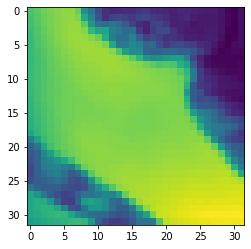

In [21]:
plt.imshow(inp)

In [12]:

class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)
        

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [11]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image

class ImageSequenceDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load the sequence of images
        images = []
        for path in self.image_paths[idx]:
            image = Image.open(path)
            if self.transform:
                image = self.transform(image).squeeze()
            images.append(image)
             # Convert the sequence of images to a tensor
        images = torch.stack(images)

        return images

In [124]:
def get_transform(image_size, crop_size):
    transform = transforms.Compose([
        transforms.Resize(image_size),   # Rescale the image to 256 pixels on the shorter side
        transforms.CenterCrop(crop_size),   # Crop the center 224x224 pixels
        transforms.Grayscale(num_output_channels=1),   # Convert the image to grayscale
        transforms.ToTensor(),   # Convert the image to a PyTorch tensor
        transforms.Normalize(0.5,0.5), #@@@ newly added after recAE
        ])
    return transform

transform = get_transform(32, 8)

In [13]:
len(fpathlist)

5274809

In [15]:
seq_len = 3
ds_rate = 1
sample_len = seq_len*ds_rate
n_samples = 50000
sample_stride = int(len(fpathlist)/n_samples)

image_paths = [fpathlist[i:i+sample_len:ds_rate] 
 for i in range(0, n_samples*sample_stride, sample_stride)]
# print(len(image_paths[50]))

In [125]:
batch_size = 512

dataset = ImageSequenceDataset(image_paths, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True,
                                         num_workers=30, persistent_workers=False, collate_fn=None, 
                                         pin_memory=False, prefetch_factor=2)
# for images in dataloader:
#     print(images.shape)
#     break

## linear autoencoder

In [ ]:
input_size = 8*8*2
hidden_size = 128
learning_rate = 0.005
# batch_size = 64
num_epochs = 15

In [16]:
model = Autoencoder(input_size, hidden_size)

# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-3)

In [17]:
train_loader = dataloader

losses = []
for epoch in range(num_epochs):
    for data in tqdm(train_loader):
        images = data
        images = images.view(images.size(0), -1)
        reconstructions = model(images)
        loss = nn.MSELoss()(reconstructions, images)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

  2%|▉                                           | 1/49 [00:33<27:02, 33.80s/it]

Epoch [1/15], Loss: 0.2492
Epoch [1/15], Loss: 0.1116
Epoch [1/15], Loss: 0.0715


 20%|████████▊                                  | 10/49 [00:34<01:18,  2.02s/it]

Epoch [1/15], Loss: 0.0482
Epoch [1/15], Loss: 0.0461
Epoch [1/15], Loss: 0.0530
Epoch [1/15], Loss: 0.0375
Epoch [1/15], Loss: 0.0387
Epoch [1/15], Loss: 0.0335
Epoch [1/15], Loss: 0.0310
Epoch [1/15], Loss: 0.0281
Epoch [1/15], Loss: 0.0252
Epoch [1/15], Loss: 0.0261
Epoch [1/15], Loss: 0.0225
Epoch [1/15], Loss: 0.0233


 45%|███████████████████▎                       | 22/49 [00:35<00:16,  1.66it/s]

Epoch [1/15], Loss: 0.0224
Epoch [1/15], Loss: 0.0207
Epoch [1/15], Loss: 0.0208
Epoch [1/15], Loss: 0.0188
Epoch [1/15], Loss: 0.0171
Epoch [1/15], Loss: 0.0163
Epoch [1/15], Loss: 0.0152
Epoch [1/15], Loss: 0.0165
Epoch [1/15], Loss: 0.0142
Epoch [1/15], Loss: 0.0147
Epoch [1/15], Loss: 0.0131


 57%|████████████████████████▌                  | 28/49 [00:35<00:08,  2.60it/s]

Epoch [1/15], Loss: 0.0131
Epoch [1/15], Loss: 0.0132
Epoch [1/15], Loss: 0.0134
Epoch [1/15], Loss: 0.0118


 63%|███████████████████████████▏               | 31/49 [01:05<00:43,  2.40s/it]

Epoch [1/15], Loss: 0.0118
Epoch [1/15], Loss: 0.0112


 67%|████████████████████████████▉              | 33/49 [01:05<00:33,  2.07s/it]

Epoch [1/15], Loss: 0.0109


 86%|████████████████████████████████████▊      | 42/49 [01:06<00:06,  1.07it/s]

Epoch [1/15], Loss: 0.0114
Epoch [1/15], Loss: 0.0106
Epoch [1/15], Loss: 0.0102
Epoch [1/15], Loss: 0.0099
Epoch [1/15], Loss: 0.0097
Epoch [1/15], Loss: 0.0094
Epoch [1/15], Loss: 0.0094
Epoch [1/15], Loss: 0.0093
Epoch [1/15], Loss: 0.0088
Epoch [1/15], Loss: 0.0085
Epoch [1/15], Loss: 0.0090


100%|███████████████████████████████████████████| 49/49 [01:06<00:00,  1.37s/it]


Epoch [1/15], Loss: 0.0091
Epoch [1/15], Loss: 0.0090
Epoch [1/15], Loss: 0.0081
Epoch [1/15], Loss: 0.0087
Epoch [1/15], Loss: 0.0080


  2%|▉                                           | 1/49 [00:24<19:49, 24.78s/it]

Epoch [2/15], Loss: 0.0080


 12%|█████▍                                      | 6/49 [00:27<01:57,  2.74s/it]

Epoch [2/15], Loss: 0.0079
Epoch [2/15], Loss: 0.0076
Epoch [2/15], Loss: 0.0075
Epoch [2/15], Loss: 0.0083
Epoch [2/15], Loss: 0.0078
Epoch [2/15], Loss: 0.0074


 29%|████████████▎                              | 14/49 [00:27<00:26,  1.34it/s]

Epoch [2/15], Loss: 0.0072
Epoch [2/15], Loss: 0.0075
Epoch [2/15], Loss: 0.0081
Epoch [2/15], Loss: 0.0075
Epoch [2/15], Loss: 0.0073
Epoch [2/15], Loss: 0.0077
Epoch [2/15], Loss: 0.0077
Epoch [2/15], Loss: 0.0075


 45%|███████████████████▎                       | 22/49 [00:29<00:11,  2.42it/s]

Epoch [2/15], Loss: 0.0074
Epoch [2/15], Loss: 0.0072
Epoch [2/15], Loss: 0.0073
Epoch [2/15], Loss: 0.0079
Epoch [2/15], Loss: 0.0070
Epoch [2/15], Loss: 0.0074
Epoch [2/15], Loss: 0.0075
Epoch [2/15], Loss: 0.0072
Epoch [2/15], Loss: 0.0079
Epoch [2/15], Loss: 0.0079


 55%|███████████████████████▋                   | 27/49 [00:29<00:05,  3.77it/s]

Epoch [2/15], Loss: 0.0072
Epoch [2/15], Loss: 0.0070
Epoch [2/15], Loss: 0.0074
Epoch [2/15], Loss: 0.0071
Epoch [2/15], Loss: 0.0074


 63%|███████████████████████████▏               | 31/49 [00:51<00:32,  1.78s/it]

Epoch [2/15], Loss: 0.0068


 71%|██████████████████████████████▋            | 35/49 [00:52<00:17,  1.25s/it]

Epoch [2/15], Loss: 0.0072
Epoch [2/15], Loss: 0.0073
Epoch [2/15], Loss: 0.0071
Epoch [2/15], Loss: 0.0071
Epoch [2/15], Loss: 0.0072


 78%|█████████████████████████████████▎         | 38/49 [00:52<00:09,  1.11it/s]

Epoch [2/15], Loss: 0.0069
Epoch [2/15], Loss: 0.0072


 84%|███████████████████████████████████▉       | 41/49 [00:54<00:05,  1.34it/s]

Epoch [2/15], Loss: 0.0075
Epoch [2/15], Loss: 0.0072
Epoch [2/15], Loss: 0.0067
Epoch [2/15], Loss: 0.0070
Epoch [2/15], Loss: 0.0070
Epoch [2/15], Loss: 0.0071
Epoch [2/15], Loss: 0.0075


100%|███████████████████████████████████████████| 49/49 [00:56<00:00,  1.16s/it]


Epoch [2/15], Loss: 0.0069
Epoch [2/15], Loss: 0.0069
Epoch [2/15], Loss: 0.0071
Epoch [2/15], Loss: 0.0069


  2%|▉                                           | 1/49 [00:23<18:35, 23.23s/it]

Epoch [3/15], Loss: 0.0068
Epoch [3/15], Loss: 0.0065


  6%|██▋                                         | 3/49 [00:24<04:52,  6.36s/it]

Epoch [3/15], Loss: 0.0065


 14%|██████▎                                     | 7/49 [00:26<01:23,  1.98s/it]

Epoch [3/15], Loss: 0.0070
Epoch [3/15], Loss: 0.0068
Epoch [3/15], Loss: 0.0068
Epoch [3/15], Loss: 0.0072
Epoch [3/15], Loss: 0.0066


 27%|███████████▍                               | 13/49 [00:26<00:24,  1.49it/s]

Epoch [3/15], Loss: 0.0068
Epoch [3/15], Loss: 0.0070
Epoch [3/15], Loss: 0.0069
Epoch [3/15], Loss: 0.0074
Epoch [3/15], Loss: 0.0067
Epoch [3/15], Loss: 0.0070


 39%|████████████████▋                          | 19/49 [00:26<00:09,  3.30it/s]

Epoch [3/15], Loss: 0.0071
Epoch [3/15], Loss: 0.0071
Epoch [3/15], Loss: 0.0068
Epoch [3/15], Loss: 0.0064
Epoch [3/15], Loss: 0.0069
Epoch [3/15], Loss: 0.0070


 53%|██████████████████████▊                    | 26/49 [00:26<00:03,  6.91it/s]

Epoch [3/15], Loss: 0.0063
Epoch [3/15], Loss: 0.0071
Epoch [3/15], Loss: 0.0067
Epoch [3/15], Loss: 0.0066
Epoch [3/15], Loss: 0.0066
Epoch [3/15], Loss: 0.0071
Epoch [3/15], Loss: 0.0065


 59%|█████████████████████████▍                 | 29/49 [00:27<00:02,  8.91it/s]

Epoch [3/15], Loss: 0.0070
Epoch [3/15], Loss: 0.0070
Epoch [3/15], Loss: 0.0070


 63%|███████████████████████████▏               | 31/49 [00:48<00:44,  2.47s/it]

Epoch [3/15], Loss: 0.0068
Epoch [3/15], Loss: 0.0066


 78%|█████████████████████████████████▎         | 38/49 [00:50<00:12,  1.12s/it]

Epoch [3/15], Loss: 0.0066
Epoch [3/15], Loss: 0.0063
Epoch [3/15], Loss: 0.0067
Epoch [3/15], Loss: 0.0066
Epoch [3/15], Loss: 0.0068
Epoch [3/15], Loss: 0.0069


 96%|█████████████████████████████████████████▏ | 47/49 [00:51<00:00,  2.04it/s]

Epoch [3/15], Loss: 0.0067
Epoch [3/15], Loss: 0.0067
Epoch [3/15], Loss: 0.0070
Epoch [3/15], Loss: 0.0075
Epoch [3/15], Loss: 0.0068
Epoch [3/15], Loss: 0.0066
Epoch [3/15], Loss: 0.0064
Epoch [3/15], Loss: 0.0068
Epoch [3/15], Loss: 0.0069
Epoch [3/15], Loss: 0.0067
Epoch [3/15], Loss: 0.0069


  6%|██▋                                         | 3/49 [00:24<04:52,  6.35s/it]

Epoch [4/15], Loss: 0.0068
Epoch [4/15], Loss: 0.0069
Epoch [4/15], Loss: 0.0071


 10%|████▍                                       | 5/49 [00:24<02:17,  3.13s/it]

Epoch [4/15], Loss: 0.0067
Epoch [4/15], Loss: 0.0069
Epoch [4/15], Loss: 0.0061
Epoch [4/15], Loss: 0.0067


 29%|████████████▎                              | 14/49 [00:24<00:21,  1.61it/s]

Epoch [4/15], Loss: 0.0066
Epoch [4/15], Loss: 0.0066
Epoch [4/15], Loss: 0.0072
Epoch [4/15], Loss: 0.0067
Epoch [4/15], Loss: 0.0067
Epoch [4/15], Loss: 0.0066
Epoch [4/15], Loss: 0.0072
Epoch [4/15], Loss: 0.0064
Epoch [4/15], Loss: 0.0065
Epoch [4/15], Loss: 0.0064
Epoch [4/15], Loss: 0.0071
Epoch [4/15], Loss: 0.0067


 53%|██████████████████████▊                    | 26/49 [00:25<00:04,  4.69it/s]

Epoch [4/15], Loss: 0.0065
Epoch [4/15], Loss: 0.0062
Epoch [4/15], Loss: 0.0065
Epoch [4/15], Loss: 0.0068
Epoch [4/15], Loss: 0.0065
Epoch [4/15], Loss: 0.0067
Epoch [4/15], Loss: 0.0064
Epoch [4/15], Loss: 0.0067
Epoch [4/15], Loss: 0.0064
Epoch [4/15], Loss: 0.0065
Epoch [4/15], Loss: 0.0069


 63%|███████████████████████████▏               | 31/49 [00:49<00:30,  1.72s/it]

Epoch [4/15], Loss: 0.0062
Epoch [4/15], Loss: 0.0067
Epoch [4/15], Loss: 0.0064


 82%|███████████████████████████████████        | 40/49 [00:50<00:07,  1.17it/s]

Epoch [4/15], Loss: 0.0067
Epoch [4/15], Loss: 0.0069
Epoch [4/15], Loss: 0.0057
Epoch [4/15], Loss: 0.0063
Epoch [4/15], Loss: 0.0066
Epoch [4/15], Loss: 0.0069
Epoch [4/15], Loss: 0.0070
Epoch [4/15], Loss: 0.0071
Epoch [4/15], Loss: 0.0067
Epoch [4/15], Loss: 0.0065
Epoch [4/15], Loss: 0.0069
Epoch [4/15], Loss: 0.0070


100%|███████████████████████████████████████████| 49/49 [00:50<00:00,  1.03s/it]


Epoch [4/15], Loss: 0.0068
Epoch [4/15], Loss: 0.0069
Epoch [4/15], Loss: 0.0067
Epoch [4/15], Loss: 0.0068


  2%|▉                                           | 1/49 [00:24<19:46, 24.72s/it]

Epoch [5/15], Loss: 0.0069


 14%|██████▎                                     | 7/49 [00:25<01:27,  2.08s/it]

Epoch [5/15], Loss: 0.0071
Epoch [5/15], Loss: 0.0063
Epoch [5/15], Loss: 0.0066
Epoch [5/15], Loss: 0.0067
Epoch [5/15], Loss: 0.0066
Epoch [5/15], Loss: 0.0066
Epoch [5/15], Loss: 0.0065
Epoch [5/15], Loss: 0.0066
Epoch [5/15], Loss: 0.0071


 27%|███████████▍                               | 13/49 [00:26<00:32,  1.11it/s]

Epoch [5/15], Loss: 0.0069
Epoch [5/15], Loss: 0.0061
Epoch [5/15], Loss: 0.0064


 45%|███████████████████▎                       | 22/49 [00:26<00:08,  3.04it/s]

Epoch [5/15], Loss: 0.0069
Epoch [5/15], Loss: 0.0064
Epoch [5/15], Loss: 0.0068
Epoch [5/15], Loss: 0.0062
Epoch [5/15], Loss: 0.0065
Epoch [5/15], Loss: 0.0066
Epoch [5/15], Loss: 0.0068
Epoch [5/15], Loss: 0.0063
Epoch [5/15], Loss: 0.0064


 51%|█████████████████████▉                     | 25/49 [00:27<00:05,  4.03it/s]

Epoch [5/15], Loss: 0.0063
Epoch [5/15], Loss: 0.0069
Epoch [5/15], Loss: 0.0070
Epoch [5/15], Loss: 0.0069
Epoch [5/15], Loss: 0.0066


 57%|████████████████████████▌                  | 28/49 [00:27<00:03,  5.27it/s]

Epoch [5/15], Loss: 0.0069
Epoch [5/15], Loss: 0.0063
Epoch [5/15], Loss: 0.0066


 63%|███████████████████████████▏               | 31/49 [00:49<00:41,  2.33s/it]

Epoch [5/15], Loss: 0.0067
Epoch [5/15], Loss: 0.0064


 78%|█████████████████████████████████▎         | 38/49 [00:50<00:12,  1.10s/it]

Epoch [5/15], Loss: 0.0066
Epoch [5/15], Loss: 0.0068
Epoch [5/15], Loss: 0.0068
Epoch [5/15], Loss: 0.0063
Epoch [5/15], Loss: 0.0068
Epoch [5/15], Loss: 0.0067
Epoch [5/15], Loss: 0.0070


 84%|███████████████████████████████████▉       | 41/49 [00:51<00:07,  1.13it/s]

Epoch [5/15], Loss: 0.0067
Epoch [5/15], Loss: 0.0073
Epoch [5/15], Loss: 0.0068
Epoch [5/15], Loss: 0.0068


100%|███████████████████████████████████████████| 49/49 [00:52<00:00,  1.07s/it]


Epoch [5/15], Loss: 0.0069
Epoch [5/15], Loss: 0.0061
Epoch [5/15], Loss: 0.0065
Epoch [5/15], Loss: 0.0065
Epoch [5/15], Loss: 0.0066
Epoch [5/15], Loss: 0.0067


  2%|▉                                           | 1/49 [00:24<19:29, 24.37s/it]

Epoch [6/15], Loss: 0.0064


  4%|█▊                                          | 2/49 [00:24<08:05, 10.32s/it]

Epoch [6/15], Loss: 0.0071


 16%|███████▏                                    | 8/49 [00:25<00:56,  1.38s/it]

Epoch [6/15], Loss: 0.0069
Epoch [6/15], Loss: 0.0070
Epoch [6/15], Loss: 0.0064
Epoch [6/15], Loss: 0.0070
Epoch [6/15], Loss: 0.0065
Epoch [6/15], Loss: 0.0068
Epoch [6/15], Loss: 0.0070
Epoch [6/15], Loss: 0.0066


 35%|██████████████▉                            | 17/49 [00:26<00:14,  2.25it/s]

Epoch [6/15], Loss: 0.0066
Epoch [6/15], Loss: 0.0071
Epoch [6/15], Loss: 0.0070
Epoch [6/15], Loss: 0.0066
Epoch [6/15], Loss: 0.0065
Epoch [6/15], Loss: 0.0066
Epoch [6/15], Loss: 0.0064
Epoch [6/15], Loss: 0.0069
Epoch [6/15], Loss: 0.0065
Epoch [6/15], Loss: 0.0070


 49%|█████████████████████                      | 24/49 [00:28<00:09,  2.58it/s]

Epoch [6/15], Loss: 0.0063
Epoch [6/15], Loss: 0.0069
Epoch [6/15], Loss: 0.0067
Epoch [6/15], Loss: 0.0070
Epoch [6/15], Loss: 0.0066
Epoch [6/15], Loss: 0.0068


 61%|██████████████████████████▎                | 30/49 [00:29<00:04,  4.55it/s]

Epoch [6/15], Loss: 0.0066
Epoch [6/15], Loss: 0.0065
Epoch [6/15], Loss: 0.0065
Epoch [6/15], Loss: 0.0069


 63%|███████████████████████████▏               | 31/49 [00:48<00:45,  2.53s/it]

Epoch [6/15], Loss: 0.0063


 65%|████████████████████████████               | 32/49 [00:49<00:38,  2.25s/it]

Epoch [6/15], Loss: 0.0068
Epoch [6/15], Loss: 0.0060


 69%|█████████████████████████████▊             | 34/49 [00:50<00:26,  1.80s/it]

Epoch [6/15], Loss: 0.0072


 73%|███████████████████████████████▌           | 36/49 [00:51<00:16,  1.31s/it]

Epoch [6/15], Loss: 0.0065
Epoch [6/15], Loss: 0.0066
Epoch [6/15], Loss: 0.0067
Epoch [6/15], Loss: 0.0067
Epoch [6/15], Loss: 0.0066
Epoch [6/15], Loss: 0.0065


 84%|███████████████████████████████████▉       | 41/49 [00:51<00:05,  1.51it/s]

Epoch [6/15], Loss: 0.0067
Epoch [6/15], Loss: 0.0066


 88%|█████████████████████████████████████▋     | 43/49 [00:51<00:03,  1.78it/s]

Epoch [6/15], Loss: 0.0067
Epoch [6/15], Loss: 0.0062


100%|███████████████████████████████████████████| 49/49 [00:52<00:00,  1.08s/it]


Epoch [6/15], Loss: 0.0062
Epoch [6/15], Loss: 0.0067
Epoch [6/15], Loss: 0.0068
Epoch [6/15], Loss: 0.0063
Epoch [6/15], Loss: 0.0072


  2%|▉                                           | 1/49 [00:24<19:29, 24.36s/it]

Epoch [7/15], Loss: 0.0060


  4%|█▊                                          | 2/49 [00:25<08:18, 10.60s/it]

Epoch [7/15], Loss: 0.0066
Epoch [7/15], Loss: 0.0068


  8%|███▌                                        | 4/49 [00:26<03:17,  4.39s/it]

Epoch [7/15], Loss: 0.0067
Epoch [7/15], Loss: 0.0062


 24%|██████████▌                                | 12/49 [00:27<00:29,  1.26it/s]

Epoch [7/15], Loss: 0.0065
Epoch [7/15], Loss: 0.0069
Epoch [7/15], Loss: 0.0071
Epoch [7/15], Loss: 0.0067
Epoch [7/15], Loss: 0.0064
Epoch [7/15], Loss: 0.0069
Epoch [7/15], Loss: 0.0068
Epoch [7/15], Loss: 0.0070
Epoch [7/15], Loss: 0.0067
Epoch [7/15], Loss: 0.0070
Epoch [7/15], Loss: 0.0069


 49%|█████████████████████                      | 24/49 [00:27<00:06,  3.96it/s]

Epoch [7/15], Loss: 0.0063
Epoch [7/15], Loss: 0.0067
Epoch [7/15], Loss: 0.0070
Epoch [7/15], Loss: 0.0065
Epoch [7/15], Loss: 0.0067
Epoch [7/15], Loss: 0.0065
Epoch [7/15], Loss: 0.0069
Epoch [7/15], Loss: 0.0067
Epoch [7/15], Loss: 0.0064
Epoch [7/15], Loss: 0.0067
Epoch [7/15], Loss: 0.0066


 61%|██████████████████████████▎                | 30/49 [00:27<00:03,  6.03it/s]

Epoch [7/15], Loss: 0.0069
Epoch [7/15], Loss: 0.0070
Epoch [7/15], Loss: 0.0069


 63%|███████████████████████████▏               | 31/49 [00:51<00:37,  2.07s/it]

Epoch [7/15], Loss: 0.0071
Epoch [7/15], Loss: 0.0063
Epoch [7/15], Loss: 0.0065


 69%|█████████████████████████████▊             | 34/49 [00:51<00:24,  1.61s/it]

Epoch [7/15], Loss: 0.0066
Epoch [7/15], Loss: 0.0069


 90%|██████████████████████████████████████▌    | 44/49 [00:53<00:03,  1.43it/s]

Epoch [7/15], Loss: 0.0064
Epoch [7/15], Loss: 0.0073
Epoch [7/15], Loss: 0.0068
Epoch [7/15], Loss: 0.0069
Epoch [7/15], Loss: 0.0065
Epoch [7/15], Loss: 0.0069
Epoch [7/15], Loss: 0.0067
Epoch [7/15], Loss: 0.0065
Epoch [7/15], Loss: 0.0069
Epoch [7/15], Loss: 0.0065
Epoch [7/15], Loss: 0.0067
Epoch [7/15], Loss: 0.0070


100%|███████████████████████████████████████████| 49/49 [00:53<00:00,  1.09s/it]


Epoch [7/15], Loss: 0.0064
Epoch [7/15], Loss: 0.0068


  2%|▉                                           | 1/49 [00:21<17:19, 21.65s/it]

Epoch [8/15], Loss: 0.0069


  4%|█▊                                          | 2/49 [00:23<07:45,  9.91s/it]

Epoch [8/15], Loss: 0.0068
Epoch [8/15], Loss: 0.0068
Epoch [8/15], Loss: 0.0067


 16%|███████▏                                    | 8/49 [00:24<01:00,  1.48s/it]

Epoch [8/15], Loss: 0.0066
Epoch [8/15], Loss: 0.0065
Epoch [8/15], Loss: 0.0065
Epoch [8/15], Loss: 0.0063


 29%|████████████▎                              | 14/49 [00:24<00:21,  1.62it/s]

Epoch [8/15], Loss: 0.0069
Epoch [8/15], Loss: 0.0066
Epoch [8/15], Loss: 0.0069
Epoch [8/15], Loss: 0.0067
Epoch [8/15], Loss: 0.0066
Epoch [8/15], Loss: 0.0064
Epoch [8/15], Loss: 0.0069
Epoch [8/15], Loss: 0.0068
Epoch [8/15], Loss: 0.0069
Epoch [8/15], Loss: 0.0066
Epoch [8/15], Loss: 0.0069


 53%|██████████████████████▊                    | 26/49 [00:24<00:04,  4.67it/s]

Epoch [8/15], Loss: 0.0070
Epoch [8/15], Loss: 0.0069
Epoch [8/15], Loss: 0.0063
Epoch [8/15], Loss: 0.0065
Epoch [8/15], Loss: 0.0069
Epoch [8/15], Loss: 0.0069
Epoch [8/15], Loss: 0.0067
Epoch [8/15], Loss: 0.0064
Epoch [8/15], Loss: 0.0069
Epoch [8/15], Loss: 0.0070
Epoch [8/15], Loss: 0.0069


 63%|███████████████████████████▏               | 31/49 [00:45<00:26,  1.49s/it]

Epoch [8/15], Loss: 0.0066


 65%|████████████████████████████               | 32/49 [00:47<00:26,  1.56s/it]

Epoch [8/15], Loss: 0.0067
Epoch [8/15], Loss: 0.0067
Epoch [8/15], Loss: 0.0068
Epoch [8/15], Loss: 0.0068


 86%|████████████████████████████████████▊      | 42/49 [00:48<00:04,  1.53it/s]

Epoch [8/15], Loss: 0.0072
Epoch [8/15], Loss: 0.0066
Epoch [8/15], Loss: 0.0072
Epoch [8/15], Loss: 0.0064
Epoch [8/15], Loss: 0.0067
Epoch [8/15], Loss: 0.0071
Epoch [8/15], Loss: 0.0060
Epoch [8/15], Loss: 0.0066
Epoch [8/15], Loss: 0.0062
Epoch [8/15], Loss: 0.0067
Epoch [8/15], Loss: 0.0068


100%|███████████████████████████████████████████| 49/49 [00:48<00:00,  1.01it/s]


Epoch [8/15], Loss: 0.0069
Epoch [8/15], Loss: 0.0068
Epoch [8/15], Loss: 0.0070


  2%|▉                                           | 1/49 [00:23<18:40, 23.35s/it]

Epoch [9/15], Loss: 0.0071
Epoch [9/15], Loss: 0.0062


  6%|██▋                                         | 3/49 [00:23<04:47,  6.25s/it]

Epoch [9/15], Loss: 0.0065
Epoch [9/15], Loss: 0.0066


 10%|████▍                                       | 5/49 [00:24<02:18,  3.14s/it]

Epoch [9/15], Loss: 0.0068
Epoch [9/15], Loss: 0.0069


 27%|███████████▍                               | 13/49 [00:24<00:24,  1.46it/s]

Epoch [9/15], Loss: 0.0067
Epoch [9/15], Loss: 0.0070
Epoch [9/15], Loss: 0.0068
Epoch [9/15], Loss: 0.0067
Epoch [9/15], Loss: 0.0066
Epoch [9/15], Loss: 0.0072
Epoch [9/15], Loss: 0.0066
Epoch [9/15], Loss: 0.0068
Epoch [9/15], Loss: 0.0070
Epoch [9/15], Loss: 0.0070
Epoch [9/15], Loss: 0.0071


 51%|█████████████████████▉                     | 25/49 [00:25<00:05,  4.46it/s]

Epoch [9/15], Loss: 0.0066
Epoch [9/15], Loss: 0.0073
Epoch [9/15], Loss: 0.0069
Epoch [9/15], Loss: 0.0064
Epoch [9/15], Loss: 0.0067
Epoch [9/15], Loss: 0.0060
Epoch [9/15], Loss: 0.0061
Epoch [9/15], Loss: 0.0074
Epoch [9/15], Loss: 0.0069
Epoch [9/15], Loss: 0.0070
Epoch [9/15], Loss: 0.0062
Epoch [9/15], Loss: 0.0065
Epoch [9/15], Loss: 0.0064


 69%|█████████████████████████████▊             | 34/49 [00:48<00:18,  1.26s/it]

Epoch [9/15], Loss: 0.0064
Epoch [9/15], Loss: 0.0067
Epoch [9/15], Loss: 0.0066
Epoch [9/15], Loss: 0.0071
Epoch [9/15], Loss: 0.0071
Epoch [9/15], Loss: 0.0067


 90%|██████████████████████████████████████▌    | 44/49 [00:50<00:03,  1.55it/s]

Epoch [9/15], Loss: 0.0068
Epoch [9/15], Loss: 0.0065
Epoch [9/15], Loss: 0.0068
Epoch [9/15], Loss: 0.0068
Epoch [9/15], Loss: 0.0067
Epoch [9/15], Loss: 0.0072
Epoch [9/15], Loss: 0.0071
Epoch [9/15], Loss: 0.0062
Epoch [9/15], Loss: 0.0067
Epoch [9/15], Loss: 0.0067
Epoch [9/15], Loss: 0.0072
Epoch [9/15], Loss: 0.0067


100%|███████████████████████████████████████████| 49/49 [00:50<00:00,  1.03s/it]


Epoch [9/15], Loss: 0.0063


  2%|▉                                           | 1/49 [00:23<18:40, 23.35s/it]

Epoch [10/15], Loss: 0.0070


  8%|███▌                                        | 4/49 [00:25<03:00,  4.00s/it]

Epoch [10/15], Loss: 0.0071
Epoch [10/15], Loss: 0.0070
Epoch [10/15], Loss: 0.0070
Epoch [10/15], Loss: 0.0071


 18%|████████                                    | 9/49 [00:25<00:49,  1.25s/it]

Epoch [10/15], Loss: 0.0070
Epoch [10/15], Loss: 0.0068
Epoch [10/15], Loss: 0.0067
Epoch [10/15], Loss: 0.0068
Epoch [10/15], Loss: 0.0068
Epoch [10/15], Loss: 0.0064
Epoch [10/15], Loss: 0.0068


 39%|████████████████▋                          | 19/49 [00:26<00:12,  2.39it/s]

Epoch [10/15], Loss: 0.0067
Epoch [10/15], Loss: 0.0067
Epoch [10/15], Loss: 0.0064
Epoch [10/15], Loss: 0.0068
Epoch [10/15], Loss: 0.0069
Epoch [10/15], Loss: 0.0064
Epoch [10/15], Loss: 0.0069
Epoch [10/15], Loss: 0.0065
Epoch [10/15], Loss: 0.0068
Epoch [10/15], Loss: 0.0068
Epoch [10/15], Loss: 0.0072


 51%|█████████████████████▉                     | 25/49 [00:26<00:06,  3.93it/s]

Epoch [10/15], Loss: 0.0070
Epoch [10/15], Loss: 0.0068
Epoch [10/15], Loss: 0.0065
Epoch [10/15], Loss: 0.0068
Epoch [10/15], Loss: 0.0067
Epoch [10/15], Loss: 0.0067
Epoch [10/15], Loss: 0.0069


 63%|███████████████████████████▏               | 31/49 [00:49<00:28,  1.57s/it]

Epoch [10/15], Loss: 0.0068


 65%|████████████████████████████               | 32/49 [00:50<00:26,  1.56s/it]

Epoch [10/15], Loss: 0.0069
Epoch [10/15], Loss: 0.0062


 82%|███████████████████████████████████        | 40/49 [00:51<00:07,  1.28it/s]

Epoch [10/15], Loss: 0.0066
Epoch [10/15], Loss: 0.0064
Epoch [10/15], Loss: 0.0068
Epoch [10/15], Loss: 0.0069
Epoch [10/15], Loss: 0.0064
Epoch [10/15], Loss: 0.0069
Epoch [10/15], Loss: 0.0063
Epoch [10/15], Loss: 0.0069
Epoch [10/15], Loss: 0.0069
Epoch [10/15], Loss: 0.0068
Epoch [10/15], Loss: 0.0069


100%|███████████████████████████████████████████| 49/49 [00:52<00:00,  1.06s/it]


Epoch [10/15], Loss: 0.0069
Epoch [10/15], Loss: 0.0062
Epoch [10/15], Loss: 0.0066
Epoch [10/15], Loss: 0.0061
Epoch [10/15], Loss: 0.0062


 10%|████▍                                       | 5/49 [00:25<02:45,  3.75s/it]

Epoch [11/15], Loss: 0.0063
Epoch [11/15], Loss: 0.0070
Epoch [11/15], Loss: 0.0066
Epoch [11/15], Loss: 0.0070
Epoch [11/15], Loss: 0.0068
Epoch [11/15], Loss: 0.0067
Epoch [11/15], Loss: 0.0067
Epoch [11/15], Loss: 0.0067


 24%|██████████▌                                | 12/49 [00:26<00:43,  1.17s/it]

Epoch [11/15], Loss: 0.0066
Epoch [11/15], Loss: 0.0068
Epoch [11/15], Loss: 0.0065
Epoch [11/15], Loss: 0.0067
Epoch [11/15], Loss: 0.0066
Epoch [11/15], Loss: 0.0070


 39%|████████████████▋                          | 19/49 [00:26<00:14,  2.08it/s]

Epoch [11/15], Loss: 0.0066
Epoch [11/15], Loss: 0.0066
Epoch [11/15], Loss: 0.0074
Epoch [11/15], Loss: 0.0065
Epoch [11/15], Loss: 0.0070
Epoch [11/15], Loss: 0.0074


 59%|█████████████████████████▍                 | 29/49 [00:26<00:03,  5.35it/s]

Epoch [11/15], Loss: 0.0069
Epoch [11/15], Loss: 0.0069
Epoch [11/15], Loss: 0.0068
Epoch [11/15], Loss: 0.0066
Epoch [11/15], Loss: 0.0067
Epoch [11/15], Loss: 0.0066
Epoch [11/15], Loss: 0.0070
Epoch [11/15], Loss: 0.0071
Epoch [11/15], Loss: 0.0070
Epoch [11/15], Loss: 0.0066


 76%|████████████████████████████████▍          | 37/49 [00:51<00:15,  1.30s/it]

Epoch [11/15], Loss: 0.0067
Epoch [11/15], Loss: 0.0067
Epoch [11/15], Loss: 0.0068
Epoch [11/15], Loss: 0.0069
Epoch [11/15], Loss: 0.0067
Epoch [11/15], Loss: 0.0070
Epoch [11/15], Loss: 0.0067
Epoch [11/15], Loss: 0.0066


 98%|██████████████████████████████████████████ | 48/49 [00:52<00:00,  1.65it/s]

Epoch [11/15], Loss: 0.0067
Epoch [11/15], Loss: 0.0065
Epoch [11/15], Loss: 0.0070
Epoch [11/15], Loss: 0.0065
Epoch [11/15], Loss: 0.0063
Epoch [11/15], Loss: 0.0070
Epoch [11/15], Loss: 0.0068
Epoch [11/15], Loss: 0.0067
Epoch [11/15], Loss: 0.0064
Epoch [11/15], Loss: 0.0066
Epoch [11/15], Loss: 0.0065


  2%|▉                                           | 1/49 [00:25<20:23, 25.50s/it]

Epoch [12/15], Loss: 0.0070
Epoch [12/15], Loss: 0.0072


 18%|████████                                    | 9/49 [00:25<01:04,  1.62s/it]

Epoch [12/15], Loss: 0.0072
Epoch [12/15], Loss: 0.0062
Epoch [12/15], Loss: 0.0067
Epoch [12/15], Loss: 0.0064
Epoch [12/15], Loss: 0.0070
Epoch [12/15], Loss: 0.0066
Epoch [12/15], Loss: 0.0065
Epoch [12/15], Loss: 0.0067
Epoch [12/15], Loss: 0.0069


 39%|████████████████▋                          | 19/49 [00:26<00:16,  1.87it/s]

Epoch [12/15], Loss: 0.0071
Epoch [12/15], Loss: 0.0069
Epoch [12/15], Loss: 0.0070
Epoch [12/15], Loss: 0.0072
Epoch [12/15], Loss: 0.0065
Epoch [12/15], Loss: 0.0064
Epoch [12/15], Loss: 0.0069
Epoch [12/15], Loss: 0.0066
Epoch [12/15], Loss: 0.0071
Epoch [12/15], Loss: 0.0070
Epoch [12/15], Loss: 0.0071


 51%|█████████████████████▉                     | 25/49 [00:26<00:07,  3.07it/s]

Epoch [12/15], Loss: 0.0067
Epoch [12/15], Loss: 0.0063
Epoch [12/15], Loss: 0.0067
Epoch [12/15], Loss: 0.0065
Epoch [12/15], Loss: 0.0067
Epoch [12/15], Loss: 0.0071
Epoch [12/15], Loss: 0.0066
Epoch [12/15], Loss: 0.0069


 63%|███████████████████████████▏               | 31/49 [00:50<00:29,  1.64s/it]

Epoch [12/15], Loss: 0.0067
Epoch [12/15], Loss: 0.0070


 67%|████████████████████████████▉              | 33/49 [00:51<00:23,  1.47s/it]

Epoch [12/15], Loss: 0.0068
Epoch [12/15], Loss: 0.0070
Epoch [12/15], Loss: 0.0064
Epoch [12/15], Loss: 0.0066


 86%|████████████████████████████████████▊      | 42/49 [00:51<00:04,  1.42it/s]

Epoch [12/15], Loss: 0.0069
Epoch [12/15], Loss: 0.0065
Epoch [12/15], Loss: 0.0067
Epoch [12/15], Loss: 0.0067
Epoch [12/15], Loss: 0.0065
Epoch [12/15], Loss: 0.0068
Epoch [12/15], Loss: 0.0066
Epoch [12/15], Loss: 0.0065
Epoch [12/15], Loss: 0.0064
Epoch [12/15], Loss: 0.0070
Epoch [12/15], Loss: 0.0066


100%|███████████████████████████████████████████| 49/49 [00:51<00:00,  1.06s/it]


Epoch [12/15], Loss: 0.0069
Epoch [12/15], Loss: 0.0065


  2%|▉                                           | 1/49 [00:22<18:15, 22.83s/it]

Epoch [13/15], Loss: 0.0065


  4%|█▊                                          | 2/49 [00:23<07:51, 10.03s/it]

Epoch [13/15], Loss: 0.0069


 18%|████████                                    | 9/49 [00:25<00:49,  1.24s/it]

Epoch [13/15], Loss: 0.0071
Epoch [13/15], Loss: 0.0075
Epoch [13/15], Loss: 0.0066
Epoch [13/15], Loss: 0.0071
Epoch [13/15], Loss: 0.0066
Epoch [13/15], Loss: 0.0067
Epoch [13/15], Loss: 0.0069
Epoch [13/15], Loss: 0.0073
Epoch [13/15], Loss: 0.0069
Epoch [13/15], Loss: 0.0069
Epoch [13/15], Loss: 0.0066
Epoch [13/15], Loss: 0.0071


 43%|██████████████████▍                        | 21/49 [00:25<00:09,  2.92it/s]

Epoch [13/15], Loss: 0.0069
Epoch [13/15], Loss: 0.0066
Epoch [13/15], Loss: 0.0067
Epoch [13/15], Loss: 0.0066
Epoch [13/15], Loss: 0.0068
Epoch [13/15], Loss: 0.0064
Epoch [13/15], Loss: 0.0068
Epoch [13/15], Loss: 0.0068
Epoch [13/15], Loss: 0.0063
Epoch [13/15], Loss: 0.0072
Epoch [13/15], Loss: 0.0068
Epoch [13/15], Loss: 0.0067


 55%|███████████████████████▋                   | 27/49 [00:25<00:04,  4.58it/s]

Epoch [13/15], Loss: 0.0072
Epoch [13/15], Loss: 0.0068
Epoch [13/15], Loss: 0.0069
Epoch [13/15], Loss: 0.0067


 63%|███████████████████████████▏               | 31/49 [00:46<00:28,  1.58s/it]

Epoch [13/15], Loss: 0.0068


 78%|█████████████████████████████████▎         | 38/49 [00:48<00:10,  1.09it/s]

Epoch [13/15], Loss: 0.0064
Epoch [13/15], Loss: 0.0068
Epoch [13/15], Loss: 0.0068
Epoch [13/15], Loss: 0.0069
Epoch [13/15], Loss: 0.0068
Epoch [13/15], Loss: 0.0065
Epoch [13/15], Loss: 0.0070
Epoch [13/15], Loss: 0.0068
Epoch [13/15], Loss: 0.0064
Epoch [13/15], Loss: 0.0067
Epoch [13/15], Loss: 0.0063
Epoch [13/15], Loss: 0.0065


100%|███████████████████████████████████████████| 49/49 [00:49<00:00,  1.00s/it]


Epoch [13/15], Loss: 0.0070
Epoch [13/15], Loss: 0.0064
Epoch [13/15], Loss: 0.0068
Epoch [13/15], Loss: 0.0066
Epoch [13/15], Loss: 0.0066
Epoch [13/15], Loss: 0.0065


  2%|▉                                           | 1/49 [00:22<18:22, 22.97s/it]

Epoch [14/15], Loss: 0.0064
Epoch [14/15], Loss: 0.0067
Epoch [14/15], Loss: 0.0067


 16%|███████▏                                    | 8/49 [00:23<01:14,  1.81s/it]

Epoch [14/15], Loss: 0.0066
Epoch [14/15], Loss: 0.0068
Epoch [14/15], Loss: 0.0068
Epoch [14/15], Loss: 0.0073
Epoch [14/15], Loss: 0.0065
Epoch [14/15], Loss: 0.0064
Epoch [14/15], Loss: 0.0067
Epoch [14/15], Loss: 0.0066
Epoch [14/15], Loss: 0.0068
Epoch [14/15], Loss: 0.0069


 41%|█████████████████▌                         | 20/49 [00:24<00:13,  2.22it/s]

Epoch [14/15], Loss: 0.0069
Epoch [14/15], Loss: 0.0069
Epoch [14/15], Loss: 0.0067
Epoch [14/15], Loss: 0.0068
Epoch [14/15], Loss: 0.0067
Epoch [14/15], Loss: 0.0067
Epoch [14/15], Loss: 0.0072
Epoch [14/15], Loss: 0.0068
Epoch [14/15], Loss: 0.0068
Epoch [14/15], Loss: 0.0066
Epoch [14/15], Loss: 0.0073
Epoch [14/15], Loss: 0.0070


 53%|██████████████████████▊                    | 26/49 [00:24<00:07,  3.17it/s]

Epoch [14/15], Loss: 0.0069
Epoch [14/15], Loss: 0.0068
Epoch [14/15], Loss: 0.0067
Epoch [14/15], Loss: 0.0067
Epoch [14/15], Loss: 0.0069


 73%|███████████████████████████████▌           | 36/49 [00:47<00:15,  1.16s/it]

Epoch [14/15], Loss: 0.0068
Epoch [14/15], Loss: 0.0071
Epoch [14/15], Loss: 0.0067
Epoch [14/15], Loss: 0.0065
Epoch [14/15], Loss: 0.0070
Epoch [14/15], Loss: 0.0064
Epoch [14/15], Loss: 0.0069
Epoch [14/15], Loss: 0.0074
Epoch [14/15], Loss: 0.0070
Epoch [14/15], Loss: 0.0059
Epoch [14/15], Loss: 0.0068


100%|███████████████████████████████████████████| 49/49 [00:48<00:00,  1.02it/s]


Epoch [14/15], Loss: 0.0069
Epoch [14/15], Loss: 0.0070
Epoch [14/15], Loss: 0.0066
Epoch [14/15], Loss: 0.0065
Epoch [14/15], Loss: 0.0070
Epoch [14/15], Loss: 0.0066
Epoch [14/15], Loss: 0.0063
Epoch [14/15], Loss: 0.0067


  2%|▉                                           | 1/49 [00:23<18:51, 23.58s/it]

Epoch [15/15], Loss: 0.0067
Epoch [15/15], Loss: 0.0065


 18%|████████                                    | 9/49 [00:23<01:00,  1.50s/it]

Epoch [15/15], Loss: 0.0069
Epoch [15/15], Loss: 0.0066
Epoch [15/15], Loss: 0.0066
Epoch [15/15], Loss: 0.0068
Epoch [15/15], Loss: 0.0068
Epoch [15/15], Loss: 0.0071
Epoch [15/15], Loss: 0.0070
Epoch [15/15], Loss: 0.0066


 39%|████████████████▋                          | 19/49 [00:24<00:15,  2.00it/s]

Epoch [15/15], Loss: 0.0068
Epoch [15/15], Loss: 0.0071
Epoch [15/15], Loss: 0.0072
Epoch [15/15], Loss: 0.0065
Epoch [15/15], Loss: 0.0068
Epoch [15/15], Loss: 0.0066
Epoch [15/15], Loss: 0.0069
Epoch [15/15], Loss: 0.0063
Epoch [15/15], Loss: 0.0072
Epoch [15/15], Loss: 0.0065
Epoch [15/15], Loss: 0.0067
Epoch [15/15], Loss: 0.0066


 51%|█████████████████████▉                     | 25/49 [00:24<00:07,  3.27it/s]

Epoch [15/15], Loss: 0.0070
Epoch [15/15], Loss: 0.0063
Epoch [15/15], Loss: 0.0073
Epoch [15/15], Loss: 0.0067
Epoch [15/15], Loss: 0.0066
Epoch [15/15], Loss: 0.0067
Epoch [15/15], Loss: 0.0062
Epoch [15/15], Loss: 0.0067


 69%|█████████████████████████████▊             | 34/49 [00:48<00:19,  1.31s/it]

Epoch [15/15], Loss: 0.0068
Epoch [15/15], Loss: 0.0067
Epoch [15/15], Loss: 0.0066
Epoch [15/15], Loss: 0.0069


 90%|██████████████████████████████████████▌    | 44/49 [00:49<00:03,  1.60it/s]

Epoch [15/15], Loss: 0.0063
Epoch [15/15], Loss: 0.0071
Epoch [15/15], Loss: 0.0068
Epoch [15/15], Loss: 0.0066
Epoch [15/15], Loss: 0.0068
Epoch [15/15], Loss: 0.0067
Epoch [15/15], Loss: 0.0071
Epoch [15/15], Loss: 0.0071
Epoch [15/15], Loss: 0.0066
Epoch [15/15], Loss: 0.0065
Epoch [15/15], Loss: 0.0065
Epoch [15/15], Loss: 0.0069


100%|███████████████████████████████████████████| 49/49 [00:49<00:00,  1.01s/it]

Epoch [15/15], Loss: 0.0069
Epoch [15/15], Loss: 0.0073
Epoch [15/15], Loss: 0.0070


## Recurrent AE

In [17]:
class RecAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, seq_len):
        super(RecAutoencoder, self).__init__()
        self.hidden_size = hidden_size
        self.encoder = nn.RNN(input_size, hidden_size, batch_first=True)
        self.decoder = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)

        # Feed input through the encoder RNN
        out, _ = self.encoder(x, h0)

        # Take the last output of the encoder as the hidden state for the decoder
#         hidden = out[:, -1, :]

        # Feed the hidden state through the decoder linear layer
#         out = self.decoder(out)
        B,S,H = out.shape
        out = out.reshape(B*S,H)
        # apply the linear layer on each of the steps of the RNN output.
        out = self.decoder(out)

        return out.view(B,S,input_size)

In [18]:
def perturb_model(model, pr, p_sigma):
    # pr: perturb rate. comparable with learning rate and decay rate.
#                 w_new = w_old*(1-pr) + pr*N(0,1)
    for (name, param) in model.named_parameters():
        if 'weight' in name:   # just weights
            param.data = (1-pr) * param.data + \
            pr* torch.normal(0., p_sigma, size=param.shape)
    return
            
#         nc = param.shape[0]  # cols
#         nr = param.shape[1]  # rows
#         for i in range(nr):
#             for j in range(nc):

#                 param.data[j][i] = \
#                 ((1-pr) * param.data[j][i]) + \
#                 pr* T.normal(0., 1, size=(1,1))
#     return

In [19]:
# pr = 1e-3


In [21]:
input_size = 8*8
hidden_size = 16 #64
lr = 5e-3
dr = 1e-3 #1e-3
pr = 1e-4 #1e-3
p_sigma = 1./hidden_size
# batch_size = 64
num_epochs = 10

# also change: normalize the input around 0

In [131]:
model = RecAutoencoder(input_size, hidden_size, seq_len)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=dr)

In [132]:
train_loader = dataloader

losses = []
for epoch in tqdm(range(num_epochs)):
    for data in tqdm(train_loader):
        perturb_model(model, pr, p_sigma)
        images = data
        B, seq_len, H,W = images.shape #512, 2, 8, 8
        images = images.view(B, seq_len, -1)
        reconstructions = model(images)
        loss = nn.MSELoss()(reconstructions, images)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

  1%|▍                                           | 1/98 [00:16<26:14, 16.23s/it]

Epoch [1/10], Loss: 0.2896



  5%|██▏                                         | 5/98 [00:17<03:21,  2.17s/it]

Epoch [1/10], Loss: 0.2468
Epoch [1/10], Loss: 0.2355
Epoch [1/10], Loss: 0.2114
Epoch [1/10], Loss: 0.2088
Epoch [1/10], Loss: 0.1772
Epoch [1/10], Loss: 0.1892



 11%|████▊                                      | 11/98 [00:18<00:56,  1.54it/s]

Epoch [1/10], Loss: 0.1702
Epoch [1/10], Loss: 0.1577
Epoch [1/10], Loss: 0.1386
Epoch [1/10], Loss: 0.1269
Epoch [1/10], Loss: 0.1116
Epoch [1/10], Loss: 0.1117



 17%|███████▍                                   | 17/98 [00:18<00:23,  3.51it/s]

Epoch [1/10], Loss: 0.1024
Epoch [1/10], Loss: 0.0946
Epoch [1/10], Loss: 0.0843
Epoch [1/10], Loss: 0.0823
Epoch [1/10], Loss: 0.0780
Epoch [1/10], Loss: 0.0637



 23%|██████████                                 | 23/98 [00:18<00:11,  6.68it/s]

Epoch [1/10], Loss: 0.0638
Epoch [1/10], Loss: 0.0664
Epoch [1/10], Loss: 0.0567
Epoch [1/10], Loss: 0.0583
Epoch [1/10], Loss: 0.0533
Epoch [1/10], Loss: 0.0520



 31%|█████████████▏                             | 30/98 [00:18<00:05, 11.75it/s]

Epoch [1/10], Loss: 0.0488
Epoch [1/10], Loss: 0.0532
Epoch [1/10], Loss: 0.0497
Epoch [1/10], Loss: 0.0499
Epoch [1/10], Loss: 0.0430
Epoch [1/10], Loss: 0.0436



 35%|██████████████▉                            | 34/98 [00:31<01:09,  1.09s/it]

Epoch [1/10], Loss: 0.0446
Epoch [1/10], Loss: 0.0399
Epoch [1/10], Loss: 0.0392
Epoch [1/10], Loss: 0.0366
Epoch [1/10], Loss: 0.0377



 38%|████████████████▏                          | 37/98 [00:31<00:44,  1.36it/s]

Epoch [1/10], Loss: 0.0402
Epoch [1/10], Loss: 0.0374
Epoch [1/10], Loss: 0.0343



 44%|██████████████████▊                        | 43/98 [00:32<00:22,  2.44it/s]

Epoch [1/10], Loss: 0.0341
Epoch [1/10], Loss: 0.0337
Epoch [1/10], Loss: 0.0337
Epoch [1/10], Loss: 0.0296
Epoch [1/10], Loss: 0.0310
Epoch [1/10], Loss: 0.0320



 50%|█████████████████████▌                     | 49/98 [00:32<00:10,  4.64it/s]

Epoch [1/10], Loss: 0.0356
Epoch [1/10], Loss: 0.0318
Epoch [1/10], Loss: 0.0286
Epoch [1/10], Loss: 0.0272
Epoch [1/10], Loss: 0.0251
Epoch [1/10], Loss: 0.0313



 56%|████████████████████████▏                  | 55/98 [00:32<00:05,  8.16it/s]

Epoch [1/10], Loss: 0.0263
Epoch [1/10], Loss: 0.0247
Epoch [1/10], Loss: 0.0283
Epoch [1/10], Loss: 0.0273
Epoch [1/10], Loss: 0.0245
Epoch [1/10], Loss: 0.0247



 59%|█████████████████████████▍                 | 58/98 [00:32<00:03, 10.32it/s]

Epoch [1/10], Loss: 0.0280
Epoch [1/10], Loss: 0.0248
Epoch [1/10], Loss: 0.0247



 62%|██████████████████████████▊                | 61/98 [00:42<00:37,  1.01s/it]

Epoch [1/10], Loss: 0.0245



 68%|█████████████████████████████▍             | 67/98 [00:44<00:19,  1.62it/s]

Epoch [1/10], Loss: 0.0251
Epoch [1/10], Loss: 0.0248
Epoch [1/10], Loss: 0.0239
Epoch [1/10], Loss: 0.0240
Epoch [1/10], Loss: 0.0234
Epoch [1/10], Loss: 0.0212
Epoch [1/10], Loss: 0.0209



 71%|██████████████████████████████▋            | 70/98 [00:44<00:12,  2.19it/s]

Epoch [1/10], Loss: 0.0219
Epoch [1/10], Loss: 0.0220
Epoch [1/10], Loss: 0.0219



 78%|█████████████████████████████████▎         | 76/98 [00:44<00:05,  4.11it/s]

Epoch [1/10], Loss: 0.0220
Epoch [1/10], Loss: 0.0230
Epoch [1/10], Loss: 0.0223
Epoch [1/10], Loss: 0.0228
Epoch [1/10], Loss: 0.0219
Epoch [1/10], Loss: 0.0209



 86%|████████████████████████████████████▊      | 84/98 [00:44<00:01,  8.25it/s]

Epoch [1/10], Loss: 0.0220
Epoch [1/10], Loss: 0.0218
Epoch [1/10], Loss: 0.0221
Epoch [1/10], Loss: 0.0214
Epoch [1/10], Loss: 0.0193
Epoch [1/10], Loss: 0.0220
Epoch [1/10], Loss: 0.0198



 90%|██████████████████████████████████████▌    | 88/98 [00:44<00:00, 10.92it/s]

Epoch [1/10], Loss: 0.0198
Epoch [1/10], Loss: 0.0201
Epoch [1/10], Loss: 0.0199
Epoch [1/10], Loss: 0.0217
Epoch [1/10], Loss: 0.0205
Epoch [1/10], Loss: 0.0204



 93%|███████████████████████████████████████▉   | 91/98 [00:54<00:06,  1.08it/s]

Epoch [1/10], Loss: 0.0195



 99%|██████████████████████████████████████████▌| 97/98 [00:56<00:00,  1.64it/s]

Epoch [1/10], Loss: 0.0188
Epoch [1/10], Loss: 0.0186
Epoch [1/10], Loss: 0.0205
Epoch [1/10], Loss: 0.0167
Epoch [1/10], Loss: 0.0187
Epoch [1/10], Loss: 0.0192


 10%|████▍                                       | 1/10 [00:56<08:31, 56.87s/it]

Epoch [1/10], Loss: 0.0178



  1%|▍                                           | 1/98 [00:10<17:19, 10.72s/it]

Epoch [2/10], Loss: 0.0177
Epoch [2/10], Loss: 0.0220



  6%|██▋                                         | 6/98 [00:11<01:46,  1.16s/it]

Epoch [2/10], Loss: 0.0162
Epoch [2/10], Loss: 0.0188
Epoch [2/10], Loss: 0.0183
Epoch [2/10], Loss: 0.0176



  8%|███▌                                        | 8/98 [00:11<01:08,  1.31it/s]

Epoch [2/10], Loss: 0.0178
Epoch [2/10], Loss: 0.0189
Epoch [2/10], Loss: 0.0188



 10%|████▍                                      | 10/98 [00:11<00:46,  1.88it/s]

Epoch [2/10], Loss: 0.0159
Epoch [2/10], Loss: 0.0183
Epoch [2/10], Loss: 0.0162



 14%|██████▏                                    | 14/98 [00:11<00:24,  3.44it/s]

Epoch [2/10], Loss: 0.0173
Epoch [2/10], Loss: 0.0169



 16%|███████                                    | 16/98 [00:12<00:18,  4.44it/s]

Epoch [2/10], Loss: 0.0173
Epoch [2/10], Loss: 0.0159
Epoch [2/10], Loss: 0.0162



 20%|████████▊                                  | 20/98 [00:12<00:11,  6.81it/s]

Epoch [2/10], Loss: 0.0186
Epoch [2/10], Loss: 0.0181
Epoch [2/10], Loss: 0.0149



 24%|██████████▌                                | 24/98 [00:12<00:07,  9.57it/s]

Epoch [2/10], Loss: 0.0162
Epoch [2/10], Loss: 0.0170
Epoch [2/10], Loss: 0.0154
Epoch [2/10], Loss: 0.0168



 28%|███████████▊                               | 27/98 [00:12<00:05, 12.74it/s]

Epoch [2/10], Loss: 0.0176
Epoch [2/10], Loss: 0.0154
Epoch [2/10], Loss: 0.0151
Epoch [2/10], Loss: 0.0164
Epoch [2/10], Loss: 0.0164
Epoch [2/10], Loss: 0.0167



 32%|█████████████▌                             | 31/98 [00:20<00:55,  1.21it/s]

Epoch [2/10], Loss: 0.0158
Epoch [2/10], Loss: 0.0149



 37%|███████████████▊                           | 36/98 [00:20<00:29,  2.08it/s]

Epoch [2/10], Loss: 0.0164
Epoch [2/10], Loss: 0.0164
Epoch [2/10], Loss: 0.0161
Epoch [2/10], Loss: 0.0152
Epoch [2/10], Loss: 0.0152
Epoch [2/10], Loss: 0.0164



 43%|██████████████████▍                        | 42/98 [00:21<00:13,  4.15it/s]

Epoch [2/10], Loss: 0.0148
Epoch [2/10], Loss: 0.0152
Epoch [2/10], Loss: 0.0150
Epoch [2/10], Loss: 0.0138
Epoch [2/10], Loss: 0.0161
Epoch [2/10], Loss: 0.0149



 49%|█████████████████████                      | 48/98 [00:21<00:06,  7.50it/s]

Epoch [2/10], Loss: 0.0147
Epoch [2/10], Loss: 0.0147
Epoch [2/10], Loss: 0.0153
Epoch [2/10], Loss: 0.0134
Epoch [2/10], Loss: 0.0157
Epoch [2/10], Loss: 0.0144



 55%|███████████████████████▋                   | 54/98 [00:21<00:03, 12.08it/s]

Epoch [2/10], Loss: 0.0153
Epoch [2/10], Loss: 0.0142
Epoch [2/10], Loss: 0.0139
Epoch [2/10], Loss: 0.0147
Epoch [2/10], Loss: 0.0148
Epoch [2/10], Loss: 0.0140



 59%|█████████████████████████▍                 | 58/98 [00:21<00:02, 15.51it/s]

Epoch [2/10], Loss: 0.0157
Epoch [2/10], Loss: 0.0142
Epoch [2/10], Loss: 0.0146
Epoch [2/10], Loss: 0.0144



 62%|██████████████████████████▊                | 61/98 [00:30<00:30,  1.19it/s]

Epoch [2/10], Loss: 0.0144
Epoch [2/10], Loss: 0.0140



 67%|████████████████████████████▉              | 66/98 [00:30<00:16,  1.93it/s]

Epoch [2/10], Loss: 0.0134
Epoch [2/10], Loss: 0.0117
Epoch [2/10], Loss: 0.0145
Epoch [2/10], Loss: 0.0144
Epoch [2/10], Loss: 0.0137
Epoch [2/10], Loss: 0.0144



 74%|████████████████████████████████           | 73/98 [00:31<00:06,  4.09it/s]

Epoch [2/10], Loss: 0.0163
Epoch [2/10], Loss: 0.0141
Epoch [2/10], Loss: 0.0145
Epoch [2/10], Loss: 0.0120
Epoch [2/10], Loss: 0.0132
Epoch [2/10], Loss: 0.0149
Epoch [2/10], Loss: 0.0148



 83%|███████████████████████████████████▌       | 81/98 [00:31<00:02,  8.05it/s]

Epoch [2/10], Loss: 0.0132
Epoch [2/10], Loss: 0.0130
Epoch [2/10], Loss: 0.0144
Epoch [2/10], Loss: 0.0136
Epoch [2/10], Loss: 0.0136
Epoch [2/10], Loss: 0.0149
Epoch [2/10], Loss: 0.0133



 91%|███████████████████████████████████████    | 89/98 [00:31<00:00, 13.42it/s]

Epoch [2/10], Loss: 0.0162
Epoch [2/10], Loss: 0.0147
Epoch [2/10], Loss: 0.0149
Epoch [2/10], Loss: 0.0142
Epoch [2/10], Loss: 0.0134
Epoch [2/10], Loss: 0.0124
Epoch [2/10], Loss: 0.0131
Epoch [2/10], Loss: 0.0139
Epoch [2/10], Loss: 0.0133
Epoch [2/10], Loss: 0.0135



 99%|██████████████████████████████████████████▌| 97/98 [00:41<00:00,  1.73it/s]

Epoch [2/10], Loss: 0.0129
Epoch [2/10], Loss: 0.0138
Epoch [2/10], Loss: 0.0120
Epoch [2/10], Loss: 0.0135
Epoch [2/10], Loss: 0.0122
Epoch [2/10], Loss: 0.0129


  3%|█▎                                          | 3/98 [00:11<04:45,  3.00s/it]

Epoch [3/10], Loss: 0.0142
Epoch [3/10], Loss: 0.0123
Epoch [3/10], Loss: 0.0128
Epoch [3/10], Loss: 0.0114



  7%|███▏                                        | 7/98 [00:11<01:20,  1.13it/s]

Epoch [3/10], Loss: 0.0149
Epoch [3/10], Loss: 0.0118
Epoch [3/10], Loss: 0.0149
Epoch [3/10], Loss: 0.0128



 12%|█████▎                                     | 12/98 [00:12<00:28,  2.97it/s]

Epoch [3/10], Loss: 0.0131
Epoch [3/10], Loss: 0.0122
Epoch [3/10], Loss: 0.0136
Epoch [3/10], Loss: 0.0137
Epoch [3/10], Loss: 0.0123



 17%|███████▍                                   | 17/98 [00:12<00:13,  5.84it/s]

Epoch [3/10], Loss: 0.0141
Epoch [3/10], Loss: 0.0118
Epoch [3/10], Loss: 0.0121
Epoch [3/10], Loss: 0.0119
Epoch [3/10], Loss: 0.0137



 23%|██████████                                 | 23/98 [00:12<00:07, 10.01it/s]

Epoch [3/10], Loss: 0.0135
Epoch [3/10], Loss: 0.0146
Epoch [3/10], Loss: 0.0120
Epoch [3/10], Loss: 0.0140
Epoch [3/10], Loss: 0.0130



 27%|███████████▍                               | 26/98 [00:12<00:05, 12.20it/s]

Epoch [3/10], Loss: 0.0140
Epoch [3/10], Loss: 0.0136
Epoch [3/10], Loss: 0.0147
Epoch [3/10], Loss: 0.0136
Epoch [3/10], Loss: 0.0141



 30%|████████████▋                              | 29/98 [00:12<00:04, 14.55it/s]

Epoch [3/10], Loss: 0.0128
Epoch [3/10], Loss: 0.0121
Epoch [3/10], Loss: 0.0127



 33%|██████████████                             | 32/98 [00:20<00:55,  1.19it/s]

Epoch [3/10], Loss: 0.0134
Epoch [3/10], Loss: 0.0136



 39%|████████████████▋                          | 38/98 [00:20<00:25,  2.39it/s]

Epoch [3/10], Loss: 0.0118
Epoch [3/10], Loss: 0.0131
Epoch [3/10], Loss: 0.0131
Epoch [3/10], Loss: 0.0127
Epoch [3/10], Loss: 0.0136
Epoch [3/10], Loss: 0.0138



 46%|███████████████████▋                       | 45/98 [00:20<00:11,  4.75it/s]

Epoch [3/10], Loss: 0.0134
Epoch [3/10], Loss: 0.0117
Epoch [3/10], Loss: 0.0129
Epoch [3/10], Loss: 0.0142
Epoch [3/10], Loss: 0.0122
Epoch [3/10], Loss: 0.0136



 52%|██████████████████████▍                    | 51/98 [00:21<00:05,  8.05it/s]

Epoch [3/10], Loss: 0.0126
Epoch [3/10], Loss: 0.0129
Epoch [3/10], Loss: 0.0131
Epoch [3/10], Loss: 0.0137
Epoch [3/10], Loss: 0.0118
Epoch [3/10], Loss: 0.0138



 55%|███████████████████████▋                   | 54/98 [00:21<00:04, 10.21it/s]

Epoch [3/10], Loss: 0.0136
Epoch [3/10], Loss: 0.0127
Epoch [3/10], Loss: 0.0130
Epoch [3/10], Loss: 0.0114
Epoch [3/10], Loss: 0.0132



 58%|█████████████████████████                  | 57/98 [00:21<00:03, 11.39it/s]

Epoch [3/10], Loss: 0.0125
Epoch [3/10], Loss: 0.0135
Epoch [3/10], Loss: 0.0131



 61%|██████████████████████████▎                | 60/98 [00:21<00:03, 11.71it/s]

Epoch [3/10], Loss: 0.0134



 64%|███████████████████████████▋               | 63/98 [00:30<00:32,  1.09it/s]

Epoch [3/10], Loss: 0.0127
Epoch [3/10], Loss: 0.0143
Epoch [3/10], Loss: 0.0139
Epoch [3/10], Loss: 0.0133



 70%|██████████████████████████████▎            | 69/98 [00:30<00:13,  2.12it/s]

Epoch [3/10], Loss: 0.0120
Epoch [3/10], Loss: 0.0120
Epoch [3/10], Loss: 0.0124
Epoch [3/10], Loss: 0.0136
Epoch [3/10], Loss: 0.0132
Epoch [3/10], Loss: 0.0120



 78%|█████████████████████████████████▎         | 76/98 [00:30<00:05,  4.26it/s]

Epoch [3/10], Loss: 0.0127
Epoch [3/10], Loss: 0.0129
Epoch [3/10], Loss: 0.0123
Epoch [3/10], Loss: 0.0114
Epoch [3/10], Loss: 0.0118
Epoch [3/10], Loss: 0.0126



 82%|███████████████████████████████████        | 80/98 [00:30<00:02,  6.09it/s]

Epoch [3/10], Loss: 0.0119
Epoch [3/10], Loss: 0.0117
Epoch [3/10], Loss: 0.0128
Epoch [3/10], Loss: 0.0122
Epoch [3/10], Loss: 0.0118
Epoch [3/10], Loss: 0.0132
Epoch [3/10], Loss: 0.0129



 90%|██████████████████████████████████████▌    | 88/98 [00:31<00:00, 11.02it/s]

Epoch [3/10], Loss: 0.0135
Epoch [3/10], Loss: 0.0113
Epoch [3/10], Loss: 0.0137
Epoch [3/10], Loss: 0.0127
Epoch [3/10], Loss: 0.0141
Epoch [3/10], Loss: 0.0126
Epoch [3/10], Loss: 0.0126



 94%|████████████████████████████████████████▎  | 92/98 [00:38<00:03,  1.61it/s]

Epoch [3/10], Loss: 0.0138
Epoch [3/10], Loss: 0.0125
Epoch [3/10], Loss: 0.0125



 97%|█████████████████████████████████████████▋ | 95/98 [00:38<00:01,  2.02it/s]

Epoch [3/10], Loss: 0.0142
Epoch [3/10], Loss: 0.0136
Epoch [3/10], Loss: 0.0123
Epoch [3/10], Loss: 0.0127
Epoch [3/10], Loss: 0.0122


  1%|▍                                           | 1/98 [00:11<18:21, 11.36s/it]

Epoch [4/10], Loss: 0.0126



  4%|█▊                                          | 4/98 [00:11<02:53,  1.84s/it]

Epoch [4/10], Loss: 0.0121
Epoch [4/10], Loss: 0.0115
Epoch [4/10], Loss: 0.0123



  9%|████                                        | 9/98 [00:11<00:46,  1.93it/s]

Epoch [4/10], Loss: 0.0125
Epoch [4/10], Loss: 0.0130
Epoch [4/10], Loss: 0.0129
Epoch [4/10], Loss: 0.0137
Epoch [4/10], Loss: 0.0127



 12%|█████▎                                     | 12/98 [00:12<00:27,  3.13it/s]

Epoch [4/10], Loss: 0.0123
Epoch [4/10], Loss: 0.0126
Epoch [4/10], Loss: 0.0133
Epoch [4/10], Loss: 0.0128
Epoch [4/10], Loss: 0.0118



 18%|███████▉                                   | 18/98 [00:12<00:12,  6.46it/s]

Epoch [4/10], Loss: 0.0117
Epoch [4/10], Loss: 0.0122
Epoch [4/10], Loss: 0.0127
Epoch [4/10], Loss: 0.0120
Epoch [4/10], Loss: 0.0124



 24%|██████████▌                                | 24/98 [00:12<00:06, 10.90it/s]

Epoch [4/10], Loss: 0.0113
Epoch [4/10], Loss: 0.0128
Epoch [4/10], Loss: 0.0125
Epoch [4/10], Loss: 0.0127
Epoch [4/10], Loss: 0.0143
Epoch [4/10], Loss: 0.0127



 31%|█████████████▏                             | 30/98 [00:12<00:04, 15.74it/s]

Epoch [4/10], Loss: 0.0121
Epoch [4/10], Loss: 0.0115
Epoch [4/10], Loss: 0.0121
Epoch [4/10], Loss: 0.0122
Epoch [4/10], Loss: 0.0118



 37%|███████████████▊                           | 36/98 [00:20<00:35,  1.74it/s]

Epoch [4/10], Loss: 0.0118
Epoch [4/10], Loss: 0.0119
Epoch [4/10], Loss: 0.0109
Epoch [4/10], Loss: 0.0139
Epoch [4/10], Loss: 0.0128
Epoch [4/10], Loss: 0.0112
Epoch [4/10], Loss: 0.0111
Epoch [4/10], Loss: 0.0115



 40%|█████████████████                          | 39/98 [00:20<00:26,  2.25it/s]

Epoch [4/10], Loss: 0.0123
Epoch [4/10], Loss: 0.0128



 44%|██████████████████▊                        | 43/98 [00:21<00:16,  3.33it/s]

Epoch [4/10], Loss: 0.0116
Epoch [4/10], Loss: 0.0134
Epoch [4/10], Loss: 0.0127



 46%|███████████████████▋                       | 45/98 [00:21<00:13,  4.07it/s]

Epoch [4/10], Loss: 0.0125
Epoch [4/10], Loss: 0.0119
Epoch [4/10], Loss: 0.0116



 51%|█████████████████████▉                     | 50/98 [00:21<00:06,  7.05it/s]

Epoch [4/10], Loss: 0.0134
Epoch [4/10], Loss: 0.0106
Epoch [4/10], Loss: 0.0112
Epoch [4/10], Loss: 0.0115
Epoch [4/10], Loss: 0.0122
Epoch [4/10], Loss: 0.0117



 57%|████████████████████████▌                  | 56/98 [00:21<00:03, 12.26it/s]

Epoch [4/10], Loss: 0.0114
Epoch [4/10], Loss: 0.0111
Epoch [4/10], Loss: 0.0139
Epoch [4/10], Loss: 0.0121
Epoch [4/10], Loss: 0.0114
Epoch [4/10], Loss: 0.0120



 60%|█████████████████████████▉                 | 59/98 [00:22<00:02, 15.07it/s]

Epoch [4/10], Loss: 0.0127
Epoch [4/10], Loss: 0.0111



 66%|████████████████████████████▌              | 65/98 [00:29<00:19,  1.72it/s]

Epoch [4/10], Loss: 0.0131
Epoch [4/10], Loss: 0.0127
Epoch [4/10], Loss: 0.0125
Epoch [4/10], Loss: 0.0119
Epoch [4/10], Loss: 0.0108
Epoch [4/10], Loss: 0.0126



 72%|███████████████████████████████▏           | 71/98 [00:29<00:08,  3.28it/s]

Epoch [4/10], Loss: 0.0127
Epoch [4/10], Loss: 0.0110
Epoch [4/10], Loss: 0.0134
Epoch [4/10], Loss: 0.0106
Epoch [4/10], Loss: 0.0119
Epoch [4/10], Loss: 0.0113



 81%|██████████████████████████████████▋        | 79/98 [00:30<00:02,  6.92it/s]

Epoch [4/10], Loss: 0.0121
Epoch [4/10], Loss: 0.0114
Epoch [4/10], Loss: 0.0139
Epoch [4/10], Loss: 0.0119
Epoch [4/10], Loss: 0.0107
Epoch [4/10], Loss: 0.0111
Epoch [4/10], Loss: 0.0127



 85%|████████████████████████████████████▍      | 83/98 [00:30<00:01,  9.31it/s]

Epoch [4/10], Loss: 0.0104
Epoch [4/10], Loss: 0.0131
Epoch [4/10], Loss: 0.0136
Epoch [4/10], Loss: 0.0127
Epoch [4/10], Loss: 0.0110
Epoch [4/10], Loss: 0.0116
Epoch [4/10], Loss: 0.0117



 89%|██████████████████████████████████████▏    | 87/98 [00:30<00:00, 12.05it/s]

Epoch [4/10], Loss: 0.0125
Epoch [4/10], Loss: 0.0106
Epoch [4/10], Loss: 0.0129
Epoch [4/10], Loss: 0.0123



 96%|█████████████████████████████████████████▏ | 94/98 [00:36<00:01,  2.43it/s]

Epoch [4/10], Loss: 0.0126
Epoch [4/10], Loss: 0.0127
Epoch [4/10], Loss: 0.0121
Epoch [4/10], Loss: 0.0113
Epoch [4/10], Loss: 0.0129
Epoch [4/10], Loss: 0.0121



 40%|█████████████████▌                          | 4/10 [02:54<04:06, 41.13s/it]

Epoch [4/10], Loss: 0.0100
Epoch [4/10], Loss: 0.0116



  1%|▍                                           | 1/98 [00:10<17:33, 10.86s/it]

Epoch [5/10], Loss: 0.0117



  5%|██▏                                         | 5/98 [00:11<02:05,  1.35s/it]

Epoch [5/10], Loss: 0.0135
Epoch [5/10], Loss: 0.0109
Epoch [5/10], Loss: 0.0123
Epoch [5/10], Loss: 0.0120
Epoch [5/10], Loss: 0.0109
Epoch [5/10], Loss: 0.0107



 11%|████▊                                      | 11/98 [00:11<00:36,  2.41it/s]

Epoch [5/10], Loss: 0.0128
Epoch [5/10], Loss: 0.0125
Epoch [5/10], Loss: 0.0115
Epoch [5/10], Loss: 0.0116
Epoch [5/10], Loss: 0.0120
Epoch [5/10], Loss: 0.0103



 17%|███████▍                                   | 17/98 [00:11<00:15,  5.22it/s]

Epoch [5/10], Loss: 0.0111
Epoch [5/10], Loss: 0.0120
Epoch [5/10], Loss: 0.0127
Epoch [5/10], Loss: 0.0112
Epoch [5/10], Loss: 0.0108
Epoch [5/10], Loss: 0.0121



 23%|██████████                                 | 23/98 [00:11<00:08,  9.33it/s]

Epoch [5/10], Loss: 0.0106
Epoch [5/10], Loss: 0.0120
Epoch [5/10], Loss: 0.0109
Epoch [5/10], Loss: 0.0122
Epoch [5/10], Loss: 0.0121
Epoch [5/10], Loss: 0.0118



 27%|███████████▍                               | 26/98 [00:12<00:06, 10.71it/s]

Epoch [5/10], Loss: 0.0121
Epoch [5/10], Loss: 0.0116



 30%|████████████▋                              | 29/98 [00:12<00:06, 10.37it/s]

Epoch [5/10], Loss: 0.0124
Epoch [5/10], Loss: 0.0116
Epoch [5/10], Loss: 0.0121



 32%|█████████████▌                             | 31/98 [00:18<00:54,  1.24it/s]

Epoch [5/10], Loss: 0.0105



 35%|██████████████▉                            | 34/98 [00:19<00:39,  1.60it/s]

Epoch [5/10], Loss: 0.0123
Epoch [5/10], Loss: 0.0117
Epoch [5/10], Loss: 0.0122



 38%|████████████████▏                          | 37/98 [00:20<00:23,  2.63it/s]

Epoch [5/10], Loss: 0.0123
Epoch [5/10], Loss: 0.0123
Epoch [5/10], Loss: 0.0120



 40%|█████████████████                          | 39/98 [00:20<00:16,  3.51it/s]

Epoch [5/10], Loss: 0.0133
Epoch [5/10], Loss: 0.0104
Epoch [5/10], Loss: 0.0117



 44%|██████████████████▊                        | 43/98 [00:20<00:09,  5.91it/s]

Epoch [5/10], Loss: 0.0121
Epoch [5/10], Loss: 0.0118
Epoch [5/10], Loss: 0.0115



 46%|███████████████████▋                       | 45/98 [00:20<00:07,  6.99it/s]

Epoch [5/10], Loss: 0.0106
Epoch [5/10], Loss: 0.0102
Epoch [5/10], Loss: 0.0115



 51%|█████████████████████▉                     | 50/98 [00:20<00:04, 11.51it/s]

Epoch [5/10], Loss: 0.0117
Epoch [5/10], Loss: 0.0124
Epoch [5/10], Loss: 0.0117
Epoch [5/10], Loss: 0.0116
Epoch [5/10], Loss: 0.0117
Epoch [5/10], Loss: 0.0100



 57%|████████████████████████▌                  | 56/98 [00:21<00:02, 16.83it/s]

Epoch [5/10], Loss: 0.0103
Epoch [5/10], Loss: 0.0118
Epoch [5/10], Loss: 0.0123
Epoch [5/10], Loss: 0.0116
Epoch [5/10], Loss: 0.0125



 60%|█████████████████████████▉                 | 59/98 [00:21<00:02, 19.33it/s]

Epoch [5/10], Loss: 0.0113
Epoch [5/10], Loss: 0.0116
Epoch [5/10], Loss: 0.0129
Epoch [5/10], Loss: 0.0118



 66%|████████████████████████████▌              | 65/98 [00:29<00:19,  1.67it/s]

Epoch [5/10], Loss: 0.0114
Epoch [5/10], Loss: 0.0110
Epoch [5/10], Loss: 0.0115
Epoch [5/10], Loss: 0.0123
Epoch [5/10], Loss: 0.0133
Epoch [5/10], Loss: 0.0137



 73%|███████████████████████████████▌           | 72/98 [00:29<00:07,  3.58it/s]

Epoch [5/10], Loss: 0.0121
Epoch [5/10], Loss: 0.0122
Epoch [5/10], Loss: 0.0114
Epoch [5/10], Loss: 0.0109
Epoch [5/10], Loss: 0.0120
Epoch [5/10], Loss: 0.0113
Epoch [5/10], Loss: 0.0124



 81%|██████████████████████████████████▋        | 79/98 [00:29<00:02,  6.80it/s]

Epoch [5/10], Loss: 0.0103
Epoch [5/10], Loss: 0.0122
Epoch [5/10], Loss: 0.0108
Epoch [5/10], Loss: 0.0126
Epoch [5/10], Loss: 0.0130
Epoch [5/10], Loss: 0.0124
Epoch [5/10], Loss: 0.0106



 89%|██████████████████████████████████████▏    | 87/98 [00:29<00:00, 11.97it/s]

Epoch [5/10], Loss: 0.0118
Epoch [5/10], Loss: 0.0121
Epoch [5/10], Loss: 0.0117
Epoch [5/10], Loss: 0.0114
Epoch [5/10], Loss: 0.0117
Epoch [5/10], Loss: 0.0115
Epoch [5/10], Loss: 0.0116
Epoch [5/10], Loss: 0.0120
Epoch [5/10], Loss: 0.0115



 93%|███████████████████████████████████████▉   | 91/98 [00:35<00:03,  1.94it/s]

Epoch [5/10], Loss: 0.0124



 96%|█████████████████████████████████████████▏ | 94/98 [00:36<00:01,  2.15it/s]

Epoch [5/10], Loss: 0.0129
Epoch [5/10], Loss: 0.0108
Epoch [5/10], Loss: 0.0115



 99%|██████████████████████████████████████████▌| 97/98 [00:36<00:00,  2.84it/s]

Epoch [5/10], Loss: 0.0114
Epoch [5/10], Loss: 0.0104
Epoch [5/10], Loss: 0.0109
Epoch [5/10], Loss: 0.0121


  3%|█▎                                          | 3/98 [00:12<05:01,  3.18s/it]

Epoch [6/10], Loss: 0.0120
Epoch [6/10], Loss: 0.0126
Epoch [6/10], Loss: 0.0108
Epoch [6/10], Loss: 0.0111



  9%|████                                        | 9/98 [00:12<01:01,  1.45it/s]

Epoch [6/10], Loss: 0.0115
Epoch [6/10], Loss: 0.0117
Epoch [6/10], Loss: 0.0113
Epoch [6/10], Loss: 0.0125
Epoch [6/10], Loss: 0.0118



 12%|█████▎                                     | 12/98 [00:12<00:36,  2.34it/s]

Epoch [6/10], Loss: 0.0115
Epoch [6/10], Loss: 0.0110
Epoch [6/10], Loss: 0.0120
Epoch [6/10], Loss: 0.0115
Epoch [6/10], Loss: 0.0122
Epoch [6/10], Loss: 0.0126



 18%|███████▉                                   | 18/98 [00:12<00:16,  4.93it/s]

Epoch [6/10], Loss: 0.0109
Epoch [6/10], Loss: 0.0112
Epoch [6/10], Loss: 0.0113
Epoch [6/10], Loss: 0.0129
Epoch [6/10], Loss: 0.0116



 26%|██████████▉                                | 25/98 [00:13<00:07,  9.52it/s]

Epoch [6/10], Loss: 0.0117
Epoch [6/10], Loss: 0.0117
Epoch [6/10], Loss: 0.0119
Epoch [6/10], Loss: 0.0113
Epoch [6/10], Loss: 0.0112
Epoch [6/10], Loss: 0.0099



 29%|████████████▎                              | 28/98 [00:13<00:05, 11.80it/s]

Epoch [6/10], Loss: 0.0105
Epoch [6/10], Loss: 0.0110
Epoch [6/10], Loss: 0.0110
Epoch [6/10], Loss: 0.0117



 32%|█████████████▌                             | 31/98 [00:20<00:51,  1.30it/s]

Epoch [6/10], Loss: 0.0113
Epoch [6/10], Loss: 0.0127



 37%|███████████████▊                           | 36/98 [00:21<00:32,  1.90it/s]

Epoch [6/10], Loss: 0.0119
Epoch [6/10], Loss: 0.0111
Epoch [6/10], Loss: 0.0099
Epoch [6/10], Loss: 0.0107



 42%|█████████████████▉                         | 41/98 [00:22<00:17,  3.34it/s]

Epoch [6/10], Loss: 0.0116
Epoch [6/10], Loss: 0.0114
Epoch [6/10], Loss: 0.0115
Epoch [6/10], Loss: 0.0118
Epoch [6/10], Loss: 0.0125



 48%|████████████████████▌                      | 47/98 [00:22<00:08,  6.32it/s]

Epoch [6/10], Loss: 0.0104
Epoch [6/10], Loss: 0.0113
Epoch [6/10], Loss: 0.0119
Epoch [6/10], Loss: 0.0106
Epoch [6/10], Loss: 0.0119
Epoch [6/10], Loss: 0.0108



 54%|███████████████████████▎                   | 53/98 [00:22<00:04, 10.64it/s]

Epoch [6/10], Loss: 0.0113
Epoch [6/10], Loss: 0.0106
Epoch [6/10], Loss: 0.0102
Epoch [6/10], Loss: 0.0112
Epoch [6/10], Loss: 0.0113
Epoch [6/10], Loss: 0.0111



 60%|█████████████████████████▉                 | 59/98 [00:22<00:02, 15.74it/s]

Epoch [6/10], Loss: 0.0116
Epoch [6/10], Loss: 0.0117
Epoch [6/10], Loss: 0.0102
Epoch [6/10], Loss: 0.0111
Epoch [6/10], Loss: 0.0102
Epoch [6/10], Loss: 0.0110
Epoch [6/10], Loss: 0.0115
Epoch [6/10], Loss: 0.0118



 63%|███████████████████████████▏               | 62/98 [00:30<00:28,  1.24it/s]

Epoch [6/10], Loss: 0.0105
Epoch [6/10], Loss: 0.0117
Epoch [6/10], Loss: 0.0110



 68%|█████████████████████████████▍             | 67/98 [00:30<00:14,  2.08it/s]

Epoch [6/10], Loss: 0.0121
Epoch [6/10], Loss: 0.0122
Epoch [6/10], Loss: 0.0116
Epoch [6/10], Loss: 0.0121



 77%|████████████████████████████████▉          | 75/98 [00:31<00:04,  4.82it/s]

Epoch [6/10], Loss: 0.0102
Epoch [6/10], Loss: 0.0116
Epoch [6/10], Loss: 0.0109
Epoch [6/10], Loss: 0.0109
Epoch [6/10], Loss: 0.0117
Epoch [6/10], Loss: 0.0118
Epoch [6/10], Loss: 0.0119



 81%|██████████████████████████████████▋        | 79/98 [00:31<00:02,  6.76it/s]

Epoch [6/10], Loss: 0.0116
Epoch [6/10], Loss: 0.0122
Epoch [6/10], Loss: 0.0115
Epoch [6/10], Loss: 0.0114
Epoch [6/10], Loss: 0.0119
Epoch [6/10], Loss: 0.0122
Epoch [6/10], Loss: 0.0122



 88%|█████████████████████████████████████▋     | 86/98 [00:31<00:01, 11.01it/s]

Epoch [6/10], Loss: 0.0119
Epoch [6/10], Loss: 0.0127
Epoch [6/10], Loss: 0.0120
Epoch [6/10], Loss: 0.0133
Epoch [6/10], Loss: 0.0123
Epoch [6/10], Loss: 0.0102
Epoch [6/10], Loss: 0.0118



 92%|███████████████████████████████████████▍   | 90/98 [00:31<00:00, 14.01it/s]

Epoch [6/10], Loss: 0.0102
Epoch [6/10], Loss: 0.0120



 95%|████████████████████████████████████████▊  | 93/98 [00:37<00:02,  1.67it/s]

Epoch [6/10], Loss: 0.0134
Epoch [6/10], Loss: 0.0117
Epoch [6/10], Loss: 0.0121



 98%|██████████████████████████████████████████ | 96/98 [00:38<00:00,  2.03it/s]

Epoch [6/10], Loss: 0.0113
Epoch [6/10], Loss: 0.0116
Epoch [6/10], Loss: 0.0124
Epoch [6/10], Loss: 0.0105


  4%|█▊                                          | 4/98 [00:10<03:12,  2.05s/it]

Epoch [7/10], Loss: 0.0115
Epoch [7/10], Loss: 0.0126
Epoch [7/10], Loss: 0.0116
Epoch [7/10], Loss: 0.0129



  7%|███▏                                        | 7/98 [00:10<01:29,  1.02it/s]

Epoch [7/10], Loss: 0.0115
Epoch [7/10], Loss: 0.0115
Epoch [7/10], Loss: 0.0113
Epoch [7/10], Loss: 0.0106
Epoch [7/10], Loss: 0.0115



 13%|█████▋                                     | 13/98 [00:11<00:31,  2.71it/s]

Epoch [7/10], Loss: 0.0102
Epoch [7/10], Loss: 0.0122
Epoch [7/10], Loss: 0.0117
Epoch [7/10], Loss: 0.0132
Epoch [7/10], Loss: 0.0111



 16%|███████                                    | 16/98 [00:11<00:20,  3.94it/s]

Epoch [7/10], Loss: 0.0113
Epoch [7/10], Loss: 0.0121
Epoch [7/10], Loss: 0.0095



 19%|████████▎                                  | 19/98 [00:12<00:19,  4.01it/s]

Epoch [7/10], Loss: 0.0119
Epoch [7/10], Loss: 0.0119



 21%|█████████▏                                 | 21/98 [00:12<00:16,  4.72it/s]

Epoch [7/10], Loss: 0.0104
Epoch [7/10], Loss: 0.0112
Epoch [7/10], Loss: 0.0110



 26%|██████████▉                                | 25/98 [00:12<00:11,  6.43it/s]

Epoch [7/10], Loss: 0.0114
Epoch [7/10], Loss: 0.0102
Epoch [7/10], Loss: 0.0113



 28%|███████████▊                               | 27/98 [00:12<00:10,  6.95it/s]

Epoch [7/10], Loss: 0.0106
Epoch [7/10], Loss: 0.0116
Epoch [7/10], Loss: 0.0114



 30%|████████████▋                              | 29/98 [00:12<00:08,  7.67it/s]

Epoch [7/10], Loss: 0.0121
Epoch [7/10], Loss: 0.0118



 34%|██████████████▍                            | 33/98 [00:18<00:43,  1.49it/s]

Epoch [7/10], Loss: 0.0134
Epoch [7/10], Loss: 0.0097
Epoch [7/10], Loss: 0.0116
Epoch [7/10], Loss: 0.0108



 38%|████████████████▏                          | 37/98 [00:19<00:22,  2.71it/s]

Epoch [7/10], Loss: 0.0106
Epoch [7/10], Loss: 0.0112
Epoch [7/10], Loss: 0.0103



 41%|█████████████████▌                         | 40/98 [00:19<00:14,  4.10it/s]

Epoch [7/10], Loss: 0.0117
Epoch [7/10], Loss: 0.0100
Epoch [7/10], Loss: 0.0106
Epoch [7/10], Loss: 0.0110
Epoch [7/10], Loss: 0.0112



 46%|███████████████████▋                       | 45/98 [00:19<00:08,  6.54it/s]

Epoch [7/10], Loss: 0.0118
Epoch [7/10], Loss: 0.0110
Epoch [7/10], Loss: 0.0106



 48%|████████████████████▌                      | 47/98 [00:19<00:07,  7.27it/s]

Epoch [7/10], Loss: 0.0122
Epoch [7/10], Loss: 0.0120



 50%|█████████████████████▌                     | 49/98 [00:20<00:06,  7.43it/s]

Epoch [7/10], Loss: 0.0107
Epoch [7/10], Loss: 0.0123
Epoch [7/10], Loss: 0.0124



 54%|███████████████████████▎                   | 53/98 [00:20<00:05,  8.84it/s]

Epoch [7/10], Loss: 0.0113
Epoch [7/10], Loss: 0.0118
Epoch [7/10], Loss: 0.0112



 56%|████████████████████████▏                  | 55/98 [00:20<00:04,  9.49it/s]

Epoch [7/10], Loss: 0.0113
Epoch [7/10], Loss: 0.0112
Epoch [7/10], Loss: 0.0103



 61%|██████████████████████████▎                | 60/98 [00:20<00:02, 13.37it/s]

Epoch [7/10], Loss: 0.0120
Epoch [7/10], Loss: 0.0124
Epoch [7/10], Loss: 0.0112
Epoch [7/10], Loss: 0.0123



 66%|████████████████████████████▌              | 65/98 [00:28<00:21,  1.52it/s]

Epoch [7/10], Loss: 0.0108
Epoch [7/10], Loss: 0.0105
Epoch [7/10], Loss: 0.0101
Epoch [7/10], Loss: 0.0125
Epoch [7/10], Loss: 0.0102
Epoch [7/10], Loss: 0.0113



 71%|██████████████████████████████▋            | 70/98 [00:28<00:10,  2.78it/s]

Epoch [7/10], Loss: 0.0109
Epoch [7/10], Loss: 0.0113
Epoch [7/10], Loss: 0.0111
Epoch [7/10], Loss: 0.0118
Epoch [7/10], Loss: 0.0112
Epoch [7/10], Loss: 0.0110



 76%|████████████████████████████████▍          | 74/98 [00:28<00:05,  4.41it/s]

Epoch [7/10], Loss: 0.0109
Epoch [7/10], Loss: 0.0114
Epoch [7/10], Loss: 0.0119
Epoch [7/10], Loss: 0.0113
Epoch [7/10], Loss: 0.0121



 84%|███████████████████████████████████▉       | 82/98 [00:29<00:01,  8.31it/s]

Epoch [7/10], Loss: 0.0109
Epoch [7/10], Loss: 0.0120
Epoch [7/10], Loss: 0.0125
Epoch [7/10], Loss: 0.0122
Epoch [7/10], Loss: 0.0120
Epoch [7/10], Loss: 0.0103
Epoch [7/10], Loss: 0.0108



 92%|███████████████████████████████████████▍   | 90/98 [00:29<00:00, 13.89it/s]

Epoch [7/10], Loss: 0.0119
Epoch [7/10], Loss: 0.0115
Epoch [7/10], Loss: 0.0120
Epoch [7/10], Loss: 0.0114
Epoch [7/10], Loss: 0.0111
Epoch [7/10], Loss: 0.0133



 95%|████████████████████████████████████████▊  | 93/98 [00:35<00:02,  1.76it/s]

Epoch [7/10], Loss: 0.0113
Epoch [7/10], Loss: 0.0113
Epoch [7/10], Loss: 0.0108
Epoch [7/10], Loss: 0.0105



 99%|██████████████████████████████████████████▌| 97/98 [00:35<00:00,  2.65it/s]

Epoch [7/10], Loss: 0.0114
Epoch [7/10], Loss: 0.0115
Epoch [7/10], Loss: 0.0120
Epoch [7/10], Loss: 0.0129


  4%|█▊                                          | 4/98 [00:11<03:24,  2.17s/it]

Epoch [8/10], Loss: 0.0118
Epoch [8/10], Loss: 0.0112
Epoch [8/10], Loss: 0.0105
Epoch [8/10], Loss: 0.0117
Epoch [8/10], Loss: 0.0119



 10%|████▍                                      | 10/98 [00:11<00:52,  1.66it/s]

Epoch [8/10], Loss: 0.0118
Epoch [8/10], Loss: 0.0109
Epoch [8/10], Loss: 0.0112
Epoch [8/10], Loss: 0.0100
Epoch [8/10], Loss: 0.0115



 16%|███████                                    | 16/98 [00:11<00:21,  3.79it/s]

Epoch [8/10], Loss: 0.0108
Epoch [8/10], Loss: 0.0111
Epoch [8/10], Loss: 0.0118
Epoch [8/10], Loss: 0.0113
Epoch [8/10], Loss: 0.0120
Epoch [8/10], Loss: 0.0113



 19%|████████▎                                  | 19/98 [00:12<00:14,  5.34it/s]


Epoch [8/10], Loss: 0.0122
Epoch [8/10], Loss: 0.0106
Epoch [8/10], Loss: 0.0107
Epoch [8/10], Loss: 0.0126
Epoch [8/10], Loss: 0.0110
Epoch [8/10], Loss: 0.0115
Epoch [8/10], Loss: 0.0121


 30%|████████████▋                              | 29/98 [00:12<00:05, 12.33it/s]

Epoch [8/10], Loss: 0.0124
Epoch [8/10], Loss: 0.0118
Epoch [8/10], Loss: 0.0111
Epoch [8/10], Loss: 0.0120
Epoch [8/10], Loss: 0.0126
Epoch [8/10], Loss: 0.0113
Epoch [8/10], Loss: 0.0114



 33%|██████████████                             | 32/98 [00:19<00:52,  1.25it/s]

Epoch [8/10], Loss: 0.0105
Epoch [8/10], Loss: 0.0110



 38%|████████████████▏                          | 37/98 [00:20<00:27,  2.18it/s]

Epoch [8/10], Loss: 0.0106
Epoch [8/10], Loss: 0.0116
Epoch [8/10], Loss: 0.0116
Epoch [8/10], Loss: 0.0110
Epoch [8/10], Loss: 0.0120
Epoch [8/10], Loss: 0.0118



 44%|██████████████████▊                        | 43/98 [00:20<00:12,  4.24it/s]

Epoch [8/10], Loss: 0.0111
Epoch [8/10], Loss: 0.0108
Epoch [8/10], Loss: 0.0116
Epoch [8/10], Loss: 0.0110
Epoch [8/10], Loss: 0.0112
Epoch [8/10], Loss: 0.0124



 50%|█████████████████████▌                     | 49/98 [00:20<00:06,  7.54it/s]

Epoch [8/10], Loss: 0.0122
Epoch [8/10], Loss: 0.0112
Epoch [8/10], Loss: 0.0116
Epoch [8/10], Loss: 0.0118
Epoch [8/10], Loss: 0.0111
Epoch [8/10], Loss: 0.0108



 56%|████████████████████████▏                  | 55/98 [00:20<00:03, 12.01it/s]

Epoch [8/10], Loss: 0.0111
Epoch [8/10], Loss: 0.0116
Epoch [8/10], Loss: 0.0118
Epoch [8/10], Loss: 0.0110
Epoch [8/10], Loss: 0.0114



 59%|█████████████████████████▍                 | 58/98 [00:21<00:03, 11.71it/s]

Epoch [8/10], Loss: 0.0106
Epoch [8/10], Loss: 0.0115
Epoch [8/10], Loss: 0.0101
Epoch [8/10], Loss: 0.0109
Epoch [8/10], Loss: 0.0108



 64%|███████████████████████████▋               | 63/98 [00:29<00:25,  1.38it/s]

Epoch [8/10], Loss: 0.0116
Epoch [8/10], Loss: 0.0112
Epoch [8/10], Loss: 0.0102
Epoch [8/10], Loss: 0.0119
Epoch [8/10], Loss: 0.0104



 71%|██████████████████████████████▋            | 70/98 [00:30<00:09,  3.05it/s]

Epoch [8/10], Loss: 0.0114
Epoch [8/10], Loss: 0.0123
Epoch [8/10], Loss: 0.0118
Epoch [8/10], Loss: 0.0106
Epoch [8/10], Loss: 0.0116
Epoch [8/10], Loss: 0.0112
Epoch [8/10], Loss: 0.0105



 80%|██████████████████████████████████▏        | 78/98 [00:30<00:03,  6.28it/s]

Epoch [8/10], Loss: 0.0116
Epoch [8/10], Loss: 0.0115
Epoch [8/10], Loss: 0.0113
Epoch [8/10], Loss: 0.0116
Epoch [8/10], Loss: 0.0120
Epoch [8/10], Loss: 0.0118
Epoch [8/10], Loss: 0.0105



 88%|█████████████████████████████████████▋     | 86/98 [00:30<00:01, 11.03it/s]

Epoch [8/10], Loss: 0.0105
Epoch [8/10], Loss: 0.0105
Epoch [8/10], Loss: 0.0115
Epoch [8/10], Loss: 0.0110
Epoch [8/10], Loss: 0.0109
Epoch [8/10], Loss: 0.0115
Epoch [8/10], Loss: 0.0107



 92%|███████████████████████████████████████▍   | 90/98 [00:30<00:00, 13.89it/s]

Epoch [8/10], Loss: 0.0103
Epoch [8/10], Loss: 0.0112
Epoch [8/10], Loss: 0.0102
Epoch [8/10], Loss: 0.0106



 98%|██████████████████████████████████████████ | 96/98 [00:38<00:01,  1.98it/s]

Epoch [8/10], Loss: 0.0111
Epoch [8/10], Loss: 0.0123
Epoch [8/10], Loss: 0.0113
Epoch [8/10], Loss: 0.0114
Epoch [8/10], Loss: 0.0106
Epoch [8/10], Loss: 0.0109
Epoch [8/10], Loss: 0.0117
Epoch [8/10], Loss: 0.0106


  2%|▉                                           | 2/98 [00:10<07:05,  4.43s/it]

Epoch [9/10], Loss: 0.0117
Epoch [9/10], Loss: 0.0099



  6%|██▋                                         | 6/98 [00:10<01:24,  1.09it/s]

Epoch [9/10], Loss: 0.0111
Epoch [9/10], Loss: 0.0125
Epoch [9/10], Loss: 0.0105
Epoch [9/10], Loss: 0.0116



 11%|████▊                                      | 11/98 [00:11<00:28,  3.07it/s]

Epoch [9/10], Loss: 0.0109
Epoch [9/10], Loss: 0.0106
Epoch [9/10], Loss: 0.0129
Epoch [9/10], Loss: 0.0107
Epoch [9/10], Loss: 0.0125



 14%|██████▏                                    | 14/98 [00:11<00:18,  4.66it/s]

Epoch [9/10], Loss: 0.0112
Epoch [9/10], Loss: 0.0118
Epoch [9/10], Loss: 0.0114
Epoch [9/10], Loss: 0.0113
Epoch [9/10], Loss: 0.0108



 17%|███████▍                                   | 17/98 [00:11<00:12,  6.55it/s]

Epoch [9/10], Loss: 0.0105
Epoch [9/10], Loss: 0.0112
Epoch [9/10], Loss: 0.0104



 22%|█████████▋                                 | 22/98 [00:11<00:08,  8.45it/s]

Epoch [9/10], Loss: 0.0115
Epoch [9/10], Loss: 0.0116
Epoch [9/10], Loss: 0.0112



 24%|██████████▌                                | 24/98 [00:12<00:08,  9.02it/s]

Epoch [9/10], Loss: 0.0105
Epoch [9/10], Loss: 0.0111
Epoch [9/10], Loss: 0.0120



 29%|████████████▎                              | 28/98 [00:12<00:06, 10.13it/s]

Epoch [9/10], Loss: 0.0112
Epoch [9/10], Loss: 0.0105
Epoch [9/10], Loss: 0.0107



 31%|█████████████▏                             | 30/98 [00:12<00:06, 10.36it/s]

Epoch [9/10], Loss: 0.0114
Epoch [9/10], Loss: 0.0107



 33%|██████████████                             | 32/98 [00:19<01:10,  1.08s/it]

Epoch [9/10], Loss: 0.0106
Epoch [9/10], Loss: 0.0113



 37%|███████████████▊                           | 36/98 [00:19<00:34,  1.78it/s]

Epoch [9/10], Loss: 0.0108
Epoch [9/10], Loss: 0.0101
Epoch [9/10], Loss: 0.0113
Epoch [9/10], Loss: 0.0120
Epoch [9/10], Loss: 0.0111
Epoch [9/10], Loss: 0.0113



 43%|██████████████████▍                        | 42/98 [00:20<00:14,  3.89it/s]

Epoch [9/10], Loss: 0.0119
Epoch [9/10], Loss: 0.0113
Epoch [9/10], Loss: 0.0117
Epoch [9/10], Loss: 0.0107
Epoch [9/10], Loss: 0.0113



 49%|█████████████████████                      | 48/98 [00:20<00:06,  7.32it/s]

Epoch [9/10], Loss: 0.0111
Epoch [9/10], Loss: 0.0107
Epoch [9/10], Loss: 0.0116
Epoch [9/10], Loss: 0.0115
Epoch [9/10], Loss: 0.0119
Epoch [9/10], Loss: 0.0109



 55%|███████████████████████▋                   | 54/98 [00:20<00:03, 11.99it/s]

Epoch [9/10], Loss: 0.0121
Epoch [9/10], Loss: 0.0115
Epoch [9/10], Loss: 0.0120
Epoch [9/10], Loss: 0.0107
Epoch [9/10], Loss: 0.0128
Epoch [9/10], Loss: 0.0116



 58%|█████████████████████████                  | 57/98 [00:20<00:02, 14.60it/s]

Epoch [9/10], Loss: 0.0106
Epoch [9/10], Loss: 0.0118
Epoch [9/10], Loss: 0.0121
Epoch [9/10], Loss: 0.0104
Epoch [9/10], Loss: 0.0116



 62%|██████████████████████████▊                | 61/98 [00:28<00:27,  1.36it/s]

Epoch [9/10], Loss: 0.0115
Epoch [9/10], Loss: 0.0123



 68%|█████████████████████████████▍             | 67/98 [00:28<00:12,  2.57it/s]

Epoch [9/10], Loss: 0.0119
Epoch [9/10], Loss: 0.0100
Epoch [9/10], Loss: 0.0089
Epoch [9/10], Loss: 0.0112
Epoch [9/10], Loss: 0.0115
Epoch [9/10], Loss: 0.0101



 74%|████████████████████████████████           | 73/98 [00:29<00:05,  4.38it/s]

Epoch [9/10], Loss: 0.0114
Epoch [9/10], Loss: 0.0117
Epoch [9/10], Loss: 0.0120
Epoch [9/10], Loss: 0.0115
Epoch [9/10], Loss: 0.0116
Epoch [9/10], Loss: 0.0103



 83%|███████████████████████████████████▌       | 81/98 [00:29<00:01,  8.63it/s]

Epoch [9/10], Loss: 0.0093
Epoch [9/10], Loss: 0.0124
Epoch [9/10], Loss: 0.0104
Epoch [9/10], Loss: 0.0112
Epoch [9/10], Loss: 0.0115
Epoch [9/10], Loss: 0.0124
Epoch [9/10], Loss: 0.0111



 87%|█████████████████████████████████████▎     | 85/98 [00:29<00:01, 11.30it/s]

Epoch [9/10], Loss: 0.0117
Epoch [9/10], Loss: 0.0106
Epoch [9/10], Loss: 0.0116
Epoch [9/10], Loss: 0.0123
Epoch [9/10], Loss: 0.0110
Epoch [9/10], Loss: 0.0116
Epoch [9/10], Loss: 0.0109



 91%|███████████████████████████████████████    | 89/98 [00:29<00:00, 14.11it/s]

Epoch [9/10], Loss: 0.0119
Epoch [9/10], Loss: 0.0104



 94%|████████████████████████████████████████▎  | 92/98 [00:35<00:03,  1.89it/s]

Epoch [9/10], Loss: 0.0103
Epoch [9/10], Loss: 0.0125



 99%|██████████████████████████████████████████▌| 97/98 [00:35<00:00,  3.06it/s]

Epoch [9/10], Loss: 0.0111
Epoch [9/10], Loss: 0.0109
Epoch [9/10], Loss: 0.0118
Epoch [9/10], Loss: 0.0105
Epoch [9/10], Loss: 0.0112
Epoch [9/10], Loss: 0.0102


  4%|█▊                                          | 4/98 [00:11<03:29,  2.23s/it]

Epoch [10/10], Loss: 0.0119
Epoch [10/10], Loss: 0.0105
Epoch [10/10], Loss: 0.0105
Epoch [10/10], Loss: 0.0107
Epoch [10/10], Loss: 0.0111
Epoch [10/10], Loss: 0.0117



  7%|███▏                                        | 7/98 [00:12<01:40,  1.10s/it]

Epoch [10/10], Loss: 0.0105



 10%|████▍                                      | 10/98 [00:13<01:03,  1.39it/s]

Epoch [10/10], Loss: 0.0111
Epoch [10/10], Loss: 0.0106
Epoch [10/10], Loss: 0.0115



 15%|██████▌                                    | 15/98 [00:13<00:24,  3.43it/s]

Epoch [10/10], Loss: 0.0105
Epoch [10/10], Loss: 0.0115
Epoch [10/10], Loss: 0.0111
Epoch [10/10], Loss: 0.0102
Epoch [10/10], Loss: 0.0120



 21%|█████████▏                                 | 21/98 [00:13<00:10,  7.23it/s]

Epoch [10/10], Loss: 0.0116
Epoch [10/10], Loss: 0.0106
Epoch [10/10], Loss: 0.0119
Epoch [10/10], Loss: 0.0115
Epoch [10/10], Loss: 0.0101
Epoch [10/10], Loss: 0.0109



 28%|███████████▊                               | 27/98 [00:13<00:05, 12.29it/s]

Epoch [10/10], Loss: 0.0107
Epoch [10/10], Loss: 0.0112
Epoch [10/10], Loss: 0.0122
Epoch [10/10], Loss: 0.0104
Epoch [10/10], Loss: 0.0101
Epoch [10/10], Loss: 0.0110



 31%|█████████████▏                             | 30/98 [00:13<00:04, 15.02it/s]

Epoch [10/10], Loss: 0.0104
Epoch [10/10], Loss: 0.0120
Epoch [10/10], Loss: 0.0116



 37%|███████████████▊                           | 36/98 [00:21<00:37,  1.65it/s]

Epoch [10/10], Loss: 0.0109
Epoch [10/10], Loss: 0.0122
Epoch [10/10], Loss: 0.0116
Epoch [10/10], Loss: 0.0124
Epoch [10/10], Loss: 0.0113
Epoch [10/10], Loss: 0.0115



 40%|█████████████████                          | 39/98 [00:21<00:25,  2.30it/s]

Epoch [10/10], Loss: 0.0112
Epoch [10/10], Loss: 0.0111
Epoch [10/10], Loss: 0.0120
Epoch [10/10], Loss: 0.0133
Epoch [10/10], Loss: 0.0111



 46%|███████████████████▋                       | 45/98 [00:22<00:12,  4.35it/s]

Epoch [10/10], Loss: 0.0111
Epoch [10/10], Loss: 0.0116
Epoch [10/10], Loss: 0.0097
Epoch [10/10], Loss: 0.0114
Epoch [10/10], Loss: 0.0115
Epoch [10/10], Loss: 0.0111



 52%|██████████████████████▍                    | 51/98 [00:22<00:06,  7.66it/s]

Epoch [10/10], Loss: 0.0109
Epoch [10/10], Loss: 0.0108
Epoch [10/10], Loss: 0.0109
Epoch [10/10], Loss: 0.0125
Epoch [10/10], Loss: 0.0113
Epoch [10/10], Loss: 0.0123



 55%|███████████████████████▋                   | 54/98 [00:22<00:04,  9.81it/s]

Epoch [10/10], Loss: 0.0111
Epoch [10/10], Loss: 0.0103
Epoch [10/10], Loss: 0.0117



 58%|█████████████████████████                  | 57/98 [00:22<00:03, 10.82it/s]

Epoch [10/10], Loss: 0.0117
Epoch [10/10], Loss: 0.0119
Epoch [10/10], Loss: 0.0123



 61%|██████████████████████████▎                | 60/98 [00:22<00:03, 10.70it/s]

Epoch [10/10], Loss: 0.0111



 63%|███████████████████████████▏               | 62/98 [00:30<00:33,  1.08it/s]

Epoch [10/10], Loss: 0.0101
Epoch [10/10], Loss: 0.0128
Epoch [10/10], Loss: 0.0110



 65%|████████████████████████████               | 64/98 [00:30<00:24,  1.37it/s]

Epoch [10/10], Loss: 0.0108



 67%|████████████████████████████▉              | 66/98 [00:31<00:18,  1.71it/s]

Epoch [10/10], Loss: 0.0123
Epoch [10/10], Loss: 0.0104



 73%|███████████████████████████████▌           | 72/98 [00:31<00:07,  3.61it/s]

Epoch [10/10], Loss: 0.0105
Epoch [10/10], Loss: 0.0109
Epoch [10/10], Loss: 0.0108
Epoch [10/10], Loss: 0.0096
Epoch [10/10], Loss: 0.0111
Epoch [10/10], Loss: 0.0115
Epoch [10/10], Loss: 0.0107



 81%|██████████████████████████████████▋        | 79/98 [00:31<00:02,  7.32it/s]

Epoch [10/10], Loss: 0.0104
Epoch [10/10], Loss: 0.0111
Epoch [10/10], Loss: 0.0102
Epoch [10/10], Loss: 0.0109
Epoch [10/10], Loss: 0.0109
Epoch [10/10], Loss: 0.0123
Epoch [10/10], Loss: 0.0119



 88%|█████████████████████████████████████▋     | 86/98 [00:32<00:00, 12.08it/s]

Epoch [10/10], Loss: 0.0112
Epoch [10/10], Loss: 0.0116
Epoch [10/10], Loss: 0.0114
Epoch [10/10], Loss: 0.0105
Epoch [10/10], Loss: 0.0108
Epoch [10/10], Loss: 0.0112



 91%|███████████████████████████████████████    | 89/98 [00:32<00:00, 14.48it/s]

Epoch [10/10], Loss: 0.0106
Epoch [10/10], Loss: 0.0106
Epoch [10/10], Loss: 0.0110
Epoch [10/10], Loss: 0.0111



 94%|████████████████████████████████████████▎  | 92/98 [00:37<00:03,  1.66it/s]

Epoch [10/10], Loss: 0.0121
Epoch [10/10], Loss: 0.0100
Epoch [10/10], Loss: 0.0118
Epoch [10/10], Loss: 0.0093



100%|███████████████████████████████████████████| 98/98 [00:38<00:00,  2.78it/s]

Epoch [10/10], Loss: 0.0120
Epoch [10/10], Loss: 0.0113
Epoch [10/10], Loss: 0.0119
Epoch [10/10], Loss: 0.0115


100%|███████████████████████████████████████████| 10/10 [06:39<00:00, 39.94s/it]


# Probe the models

In [60]:
class RecAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, seq_len, num_rnnlayers=1):
        super(RecAutoencoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_rnnlayers = num_rnnlayers
        self.encoder = nn.RNN(input_size, hidden_size, num_layers=num_rnnlayers, batch_first=True, nonlinearity='relu')
        self.decoder = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_rnnlayers, x.size(0), self.hidden_size).to(x.device)
        # Feed input through the encoder RNN
        out, _ = self.encoder(x, h0)
        # apply the linear layer on each of the steps of the RNN output.
        B,S,H = out.shape
        out = out.reshape(B*S,H)
        out = self.decoder(out)
        return out.view(B,S,input_size)

In [130]:
seq_len = 6
ds_rate = 6
num_rnnlayers = 2

sample_len = seq_len*ds_rate
n_samples = 50000
sample_stride = int(len(fpathlist)/n_samples)

image_paths = [fpathlist[i:i+sample_len:ds_rate] 
 for i in range(0, n_samples*sample_stride, sample_stride)]

dataset = ImageSequenceDataset(image_paths, transform=transform)


## Load pretrained models

In [96]:
# PATH = '/N/slate/sheybani/tmp_dir/trainedmodels/slowness_ae/rae0_h16.pt'
# model0 = torch.load(PATH)

In [146]:
PATH = '/N/slate/sheybani/tmp_dir/trainedmodels/slowness_ae/rae0_h16_v024.pt'
checkpoint = torch.load(PATH)
model0 = RecAutoencoder(input_size, hidden_size, seq_len, num_rnnlayers=num_rnnlayers)
model0.load_state_dict(checkpoint['model_state_dict'])
losses0 = checkpoint['loss']

In [147]:
PATH = '/N/slate/sheybani/tmp_dir/trainedmodels/slowness_ae/rae0_h16_v025.pt'
checkpoint = torch.load(PATH)
model2 = RecAutoencoder(input_size, hidden_size, seq_len, num_rnnlayers=num_rnnlayers)
model2.load_state_dict(checkpoint['model_state_dict'])
losses2 = checkpoint['loss']

# Probe the models

In [148]:

# print(len(image_paths[50]))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


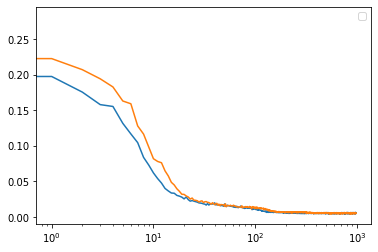

In [149]:
plt.plot(losses0)#, label='2-4mo')
plt.plot(losses2)#, label='10-12mo')
plt.xscale('log')
plt.legend()

## Compare the image reconstruction visually

In [150]:
def compare_reconstruction(images, seq_len, *models):
    n_models = len(models)
    nrow = 1+n_models
    fig,ax = plt.subplots(nrow,seq_len, figsize=(seq_len*2,2*nrow))
    
    for i_seq in range(seq_len):
        cax = ax[0,i_seq]
        cax.imshow(images[i_seq,...], cmap='gray')
        cax.set_title('t='+str(i_seq))
#         ax[0,1].imshow(images[1,...], cmap='gray')
    ax[0,0].set_ylabel('input')
    
    inp = images.view(1, seq_len,-1)
    
    for i_model in range(n_models):
        model = models[i_model]
        pred = model(inp)
        xrec = pred.reshape(seq_len,8,8).detach().numpy()
#         return xrec #@@@
        print('Reconst. err=', F.mse_loss(pred, inp))
        for i_seq in range(seq_len):
            cax = ax[1+i_model,i_seq]
            cax.imshow(xrec[0,...], cmap='gray')
        
        label = 'model '+str(i_model)+' output'
        ax[1+i_model,0].set_ylabel(label)
#     fig.tight_layout()
#     fig.subplots_adjust(wspace=0, hspace=0)
    return fig,ax

Reconst. err= tensor(0.1309, grad_fn=<MseLossBackward0>)
Reconst. err= tensor(0.1273, grad_fn=<MseLossBackward0>)


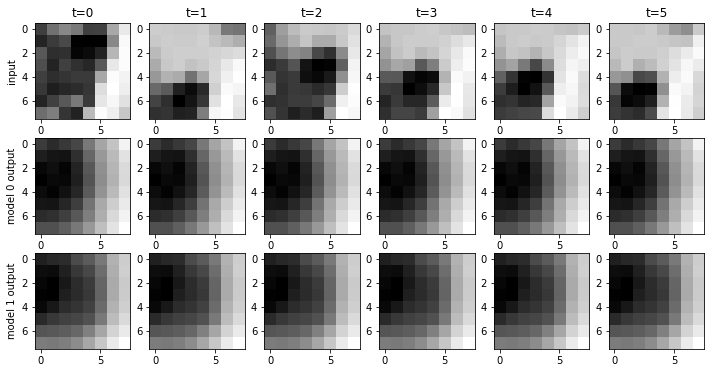

In [151]:
xtt = dataset[110]
fig,ax = compare_reconstruction(xtt, seq_len, model0, model2)

## Decoder Latent Factors

In [152]:
def get_decoder_receptive_field(recmodel, hidden_size, idx):
    stimulus = torch.zeros(hidden_size)
    stimulus[idx] = 1
    return recmodel.decoder(stimulus).reshape(8,8).detach().numpy()

Text(0.5, 0.98, 'Decoder Latent Factors')

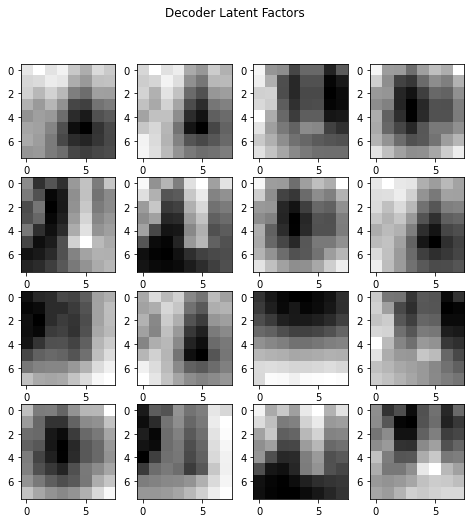

In [154]:
nrow,ncol=4,4
fig,ax = plt.subplots(nrow,ncol, figsize=(ncol*2, nrow*2))
for irow in range(nrow):
    for icol in range(ncol):
        idx = icol+irow*ncol
        ytt = get_decoder_receptive_field(model2, hidden_size, idx)
        ax[irow,icol].imshow(ytt, cmap='gray')
fig.suptitle('Decoder Latent Factors')

In [134]:
# PATH = '/N/slate/sheybani/tmp_dir/trainedmodels/slowness_ae/rae4951_h16.pt'
# torch.save(model, PATH)

## Encoder weights

In [141]:
def get_encoderw(lmodel):
    return lmodel.encoder.weight.data.detach().numpy()

def get_recencoderw(recmodel):
    return recmodel.encoder.weight_ih_l0.data.detach().numpy(), recmodel.encoder.weight_hh_l0.data.detach().numpy()

def get_recencoder_receptive_field(weights, hidden_size, idx):
    return weights[idx,:].reshape(8,8)

In [144]:
model_w, model_r = get_recencoderw(model2)

Text(0.5, 0.98, 'Encoder Weights')

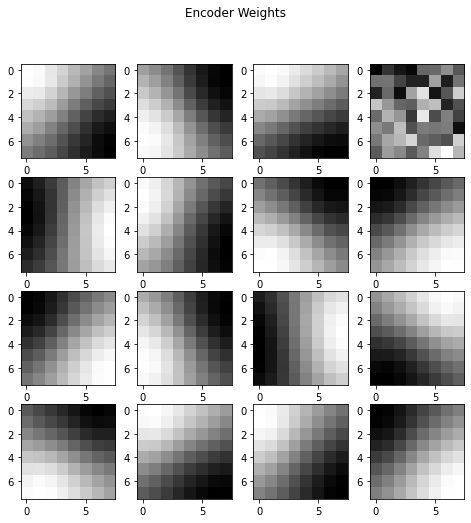

In [145]:
nrow,ncol=4,4
fig,ax = plt.subplots(nrow,ncol, figsize=(ncol*2, nrow*2))
for irow in range(nrow):
    for icol in range(ncol):
        idx = icol+irow*ncol
        ytt = get_recencoder_receptive_field(model_w, hidden_size, idx)
        ax[irow,icol].imshow(ytt, cmap='gray')
fig.suptitle('Encoder Weights')

Text(0.5, 1.0, 'Recurrent weights between hidden cells')

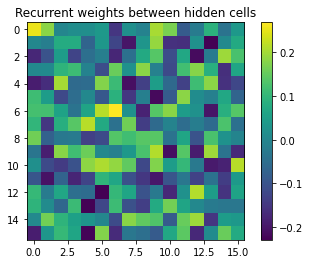

In [138]:
plt.imshow(model_0_r)
plt.colorbar()
plt.title('Recurrent weights between hidden cells')

## Measure specificity

In [52]:
c = torch.corrcoef(torch.as_tensor(model_w)).numpy()

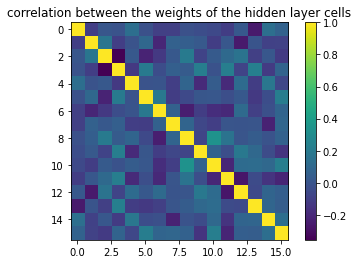

In [53]:
plt.imshow(c)
plt.title('correlation between the weights of the hidden layer cells')
plt.colorbar()

In [155]:
model_0_w, model_0_r = get_recencoderw(model0)
model_2_w, model_2_r= get_recencoderw(model2)

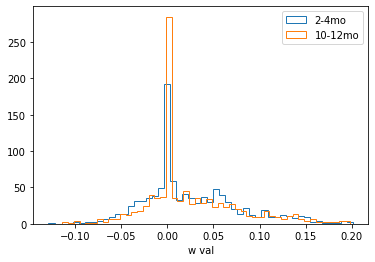

In [156]:
_ = plt.hist(model_0_w.flatten(), bins=50, histtype='step', label='2-4mo')
_ = plt.hist(model_2_w.flatten(), bins=50, histtype='step', label='10-12mo')
plt.xlabel('w val')
plt.legend()

In [56]:
c0 = torch.corrcoef(torch.as_tensor(model_0_w)).numpy()
c2 = torch.corrcoef(torch.as_tensor(model_2_w)).numpy()

Text(0.5, 0, 'correlation between the weights of the hidden layer cells')

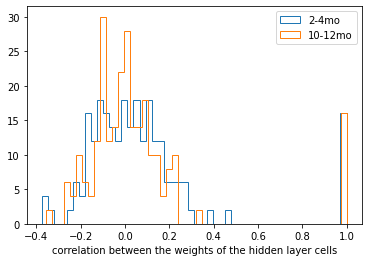

In [57]:
_ = plt.hist(c0.flatten(), bins=50, histtype='step', label='2-4mo')
_ = plt.hist(c2.flatten(), bins=50, histtype='step', label='10-12mo')
plt.legend()
plt.xlabel('correlation between the weights of the hidden layer cells')

In [9]:
def gini(x):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [40]:
w_y_cor = [np.dot(model_y_w[i,0,:],model_y_w[i,1,:])
          for i in range(128)]
w_o_cor = [np.dot(model_o_w[i,0,:],model_o_w[i,1,:])
          for i in range(128)]

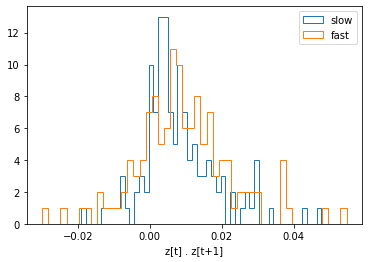

In [42]:
_ = plt.hist(w_y_cor, bins=50, histtype='step', label='slow')
_ = plt.hist(w_o_cor, bins=50, histtype='step', label='fast')
plt.xlabel('z[t] . z[t+1]')
plt.legend()

In [23]:
w_y_m = model_y_w.mean(axis=1)
w_o_m = model_o_w.mean(axis=1)

In [26]:
w_y_gini = [gini(w_y_m[i,:]) for i in range(128)]
w_o_gini = [gini(w_o_m[i,:]) for i in range(128)]

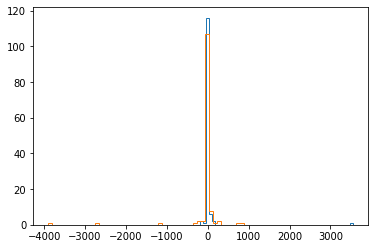

In [28]:
_ = plt.hist(w_y_gini, bins=50, histtype='step')
_ = plt.hist(w_o_gini, bins=50, histtype='step')